# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
import os

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Load Data 

Sample Data obtained from - https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption

In [ ]:
df = pd.read_csv('./data/pjm_kaggle/PJM_Load_hourly.csv')
df_raw = df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32896 entries, 0 to 32895
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Datetime     32896 non-null  object 
 1   PJM_Load_MW  32896 non-null  float64
dtypes: float64(1), object(1)
memory usage: 514.1+ KB


In [ ]:
df.head()

Datetime  PJM_Load_MW
0  1998-12-31 01:00:00      29309.0
1  1998-12-31 02:00:00      28236.0
2  1998-12-31 03:00:00      27692.0
3  1998-12-31 04:00:00      27596.0
4  1998-12-31 05:00:00      27888.0

# Clean (Basic)

In [ ]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)
df = df.sort_index()
df = df[~df.index.duplicated(keep='first')]
print(df.index.is_monotonic_increasing)

True


In [ ]:
df.rename(columns={'PJM_Load_MW': 'demand'}, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32896 entries, 1998-04-01 01:00:00 to 2002-01-01 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   demand  32896 non-null  float64
dtypes: float64(1)
memory usage: 1.5 MB


In [ ]:
print(df.isnull().sum())

demand    0
dtype: int64


In [ ]:
df = df.asfreq('H')

In [ ]:
print(df.head())
print(df.tail())
print(df.index.is_monotonic_increasing)  

                      demand
Datetime                    
1998-04-01 01:00:00  22259.0
1998-04-01 02:00:00  21244.0
1998-04-01 03:00:00  20651.0
1998-04-01 04:00:00  20421.0
1998-04-01 05:00:00  20713.0
                      demand
Datetime                    
2001-12-31 20:00:00  36392.0
2001-12-31 21:00:00  35082.0
2001-12-31 22:00:00  33890.0
2001-12-31 23:00:00  32590.0
2002-01-01 00:00:00  31569.0
True


In [ ]:
print(df.isnull().sum())

demand    8
dtype: int64


In [ ]:
null_rows = df[df.isnull().any(axis=1)]
print(null_rows)

                     demand
Datetime                   
1998-04-05 03:00:00     NaN
1998-10-25 02:00:00     NaN
1999-04-04 03:00:00     NaN
1999-10-31 02:00:00     NaN
2000-04-02 03:00:00     NaN
2000-10-29 02:00:00     NaN
2001-04-01 03:00:00     NaN
2001-10-28 02:00:00     NaN


In [ ]:
# df = df.dropna()
df['demand'] = df['demand'].fillna(df['demand'].mean())
print(df.isnull().sum())

demand    0
dtype: int64


# EDA

In [ ]:
df.describe()

demand
count  32904.000000
mean   29766.427408
std     5849.058757
min    17461.000000
25%    25473.750000
50%    29656.000000
75%    33071.250000
max    54030.000000

### Visualize Raw

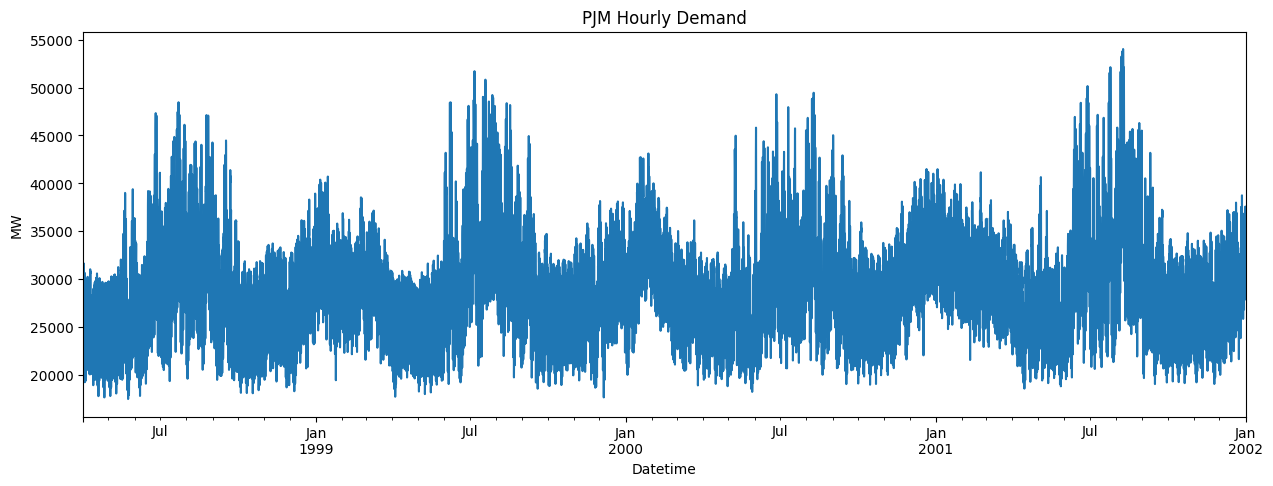

In [ ]:
plt.figure(figsize=(15,5))
df['demand'].plot(title='PJM Hourly Demand', ylabel='MW')
plt.savefig('./data/output/pjm_demand.png', dpi=300)
plt.show()

## Daily Weekly & Monthly

In [ ]:
df_daily = df['demand'].resample('D').mean()
df_weekly = df['demand'].resample('W').mean()
df_monthly = df['demand'].resample('M').mean()

### Visualize Daily

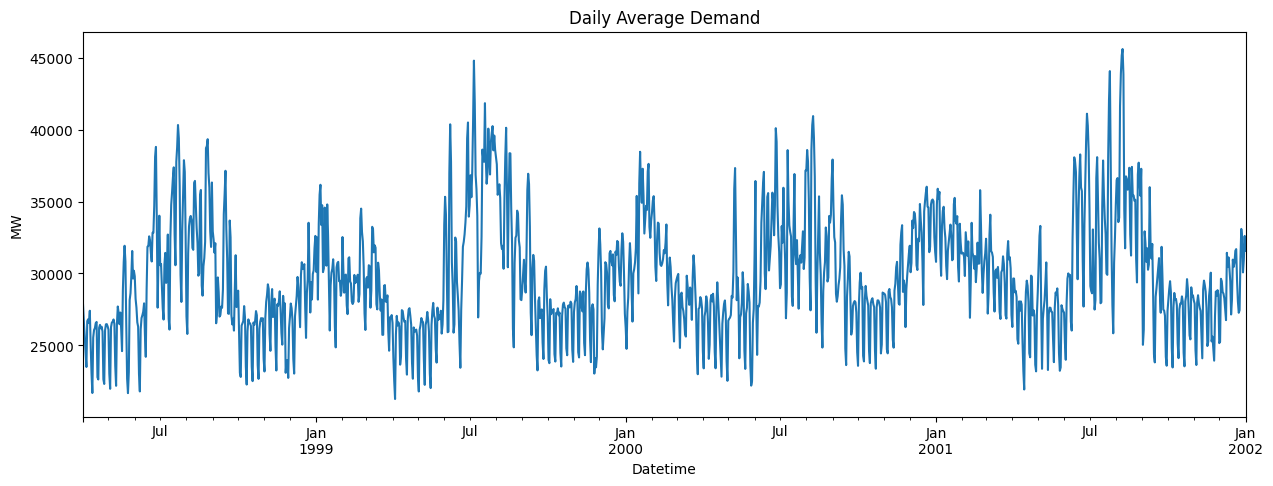

In [ ]:
plt.figure(figsize=(15,5))
df_daily.plot(title='Daily Average Demand')
plt.ylabel('MW')
plt.savefig('./data/output/pjm_demand_daily.png', dpi=300)
plt.show()

### Visualize Weekly

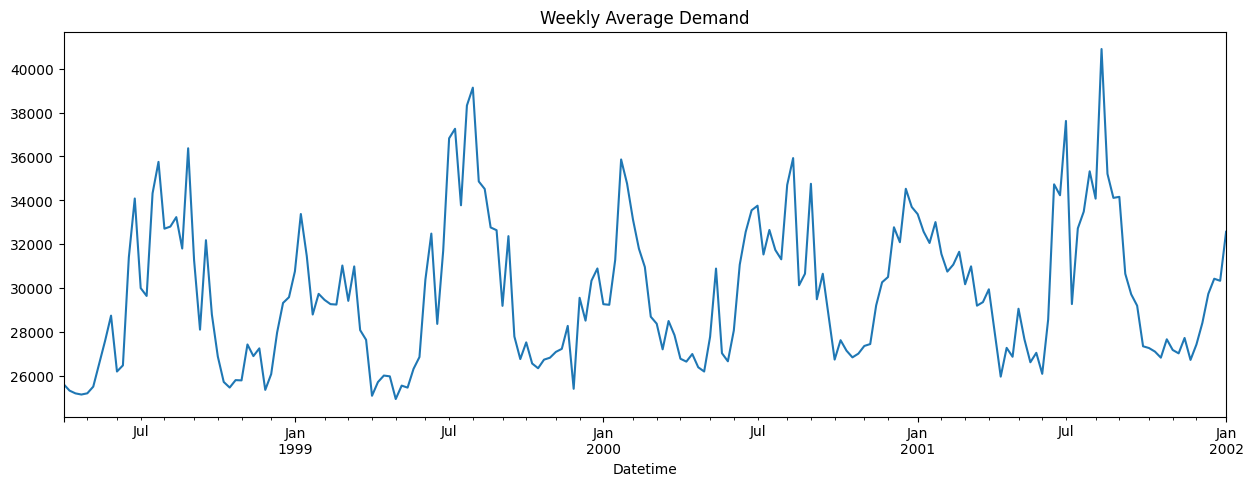

In [ ]:
df_weekly.plot(title='Weekly Average Demand', figsize=(15,5))
plt.savefig('./data/output/pjm_demand_weekly.png', dpi=300)
plt.show()

### Visualize Monthly

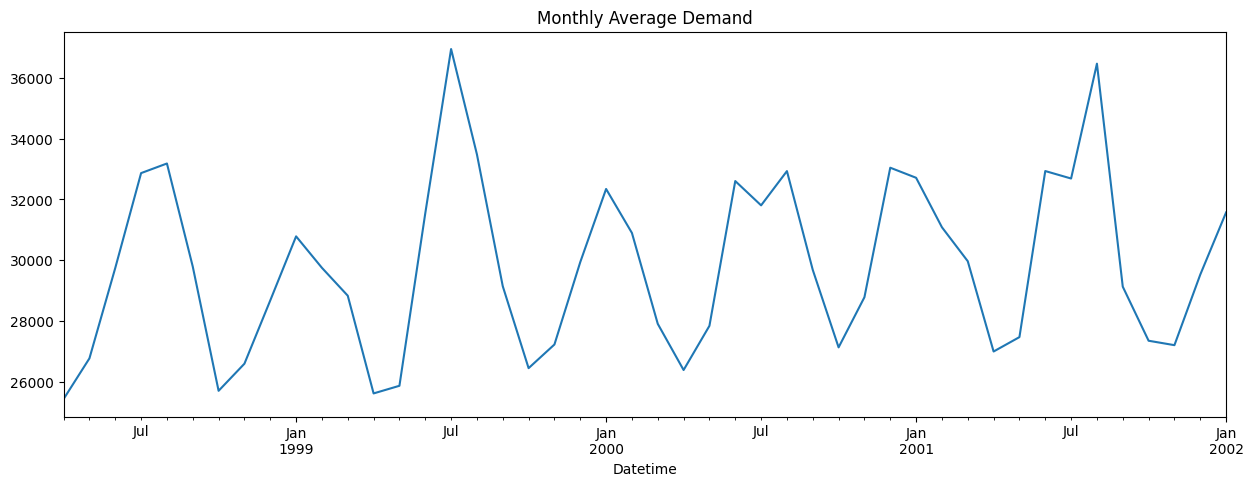

In [ ]:
df_monthly.plot(title='Monthly Average Demand', figsize=(15,5))
plt.savefig('./data/output/pjm_demand_monthly.png', dpi=300)
plt.show()

Conclusion - Hourly data is available, but hourly and daily data are too granular although they show seasonality in consumption pattern, the monthly breakdown here indicates that summer (Jun,Jul,Aug) and winters (Dec,Jan,Feb) are probably the peak consumption in every year

## By Hour, DoW, Month, year

In [ ]:
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df['year'] = df.index.year

### Visualize by hour

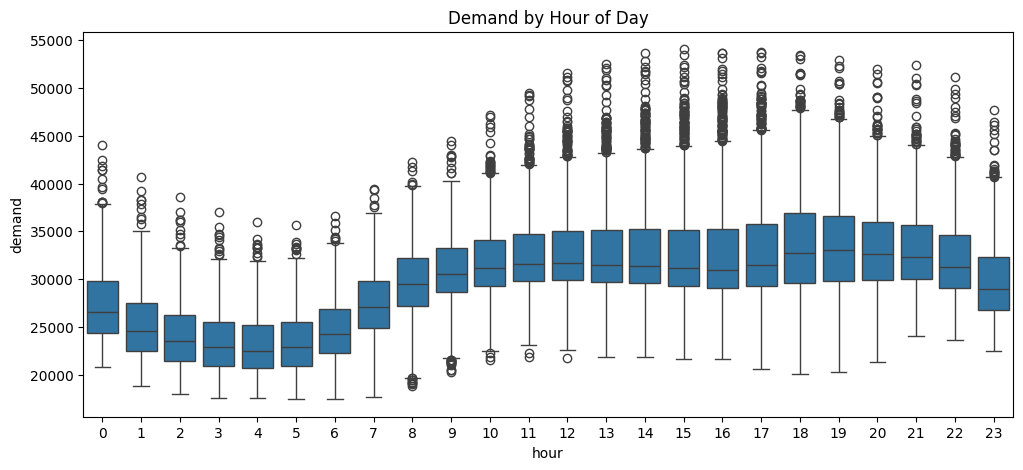

In [ ]:
plt.figure(figsize=(12,5))
sns.boxplot(x='hour', y='demand', data=df)
plt.title('Demand by Hour of Day')
plt.savefig('./data/output/pjm_demand_byhour.png', dpi=300)
plt.show()

Conclusion - drop in midnight 2-5am, consumption starts 6am and 5pm to 8pm seems the peak hours (median is quite high), although we start seeing high spikes after 2pm itself

### Visualize by DoW

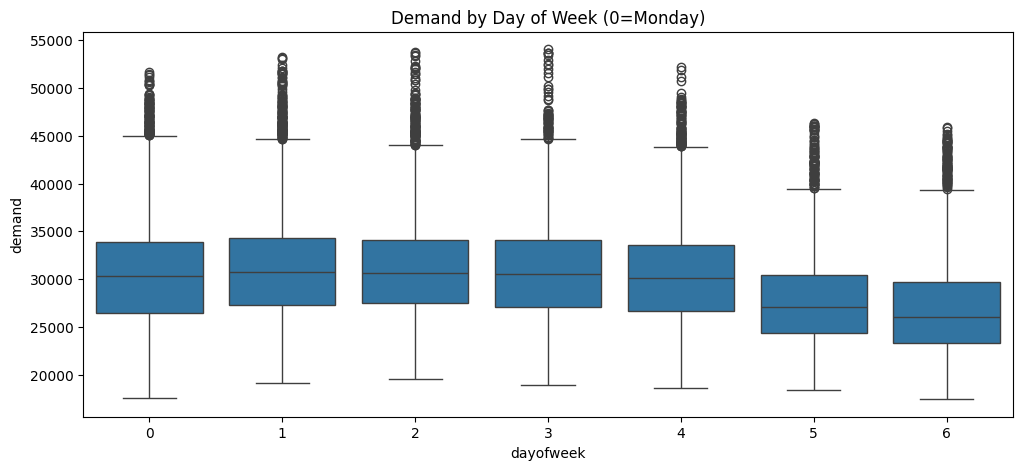

In [ ]:
plt.figure(figsize=(12,5))
sns.boxplot(x='dayofweek', y='demand', data=df)
plt.title('Demand by Day of Week (0=Monday)')
plt.savefig('./data/output/pjm_demand_bydow.png', dpi=300)
plt.show()

Conclusion - Weekends is low demands because most commercial places are closed and even in residential areas it could be possible a portion of people spend time in the outdoors

### Visualize by month

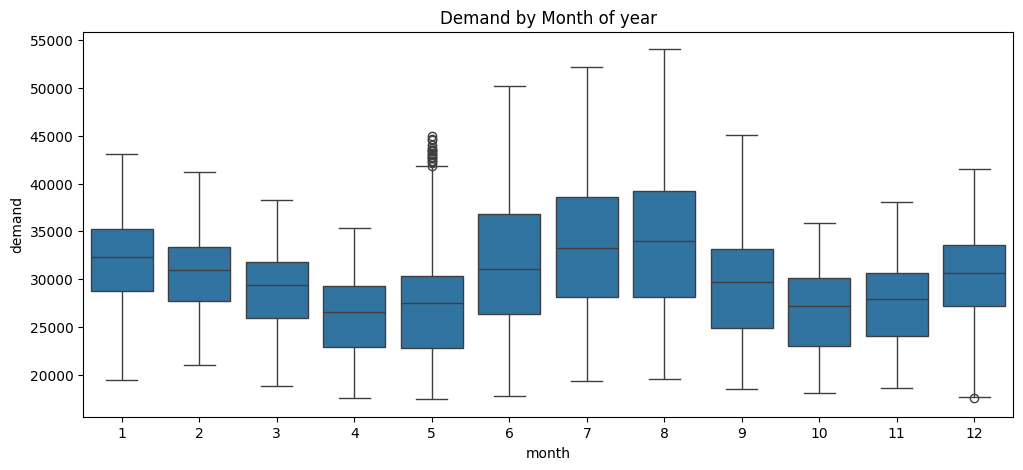

In [ ]:
plt.figure(figsize=(12,5))
sns.boxplot(x='month', y='demand', data=df)
plt.title('Demand by Month of year')
plt.savefig('./data/output/pjm_demand_bymonth.png', dpi=300)
plt.show()

Conclusion - the demand starts ramping up in June and the peak is in July and August (Air conditioning in summer probably), we also see an increase in November, December, Jan then slowing down in Feb (Heating in winters probably)

### Visualize by year

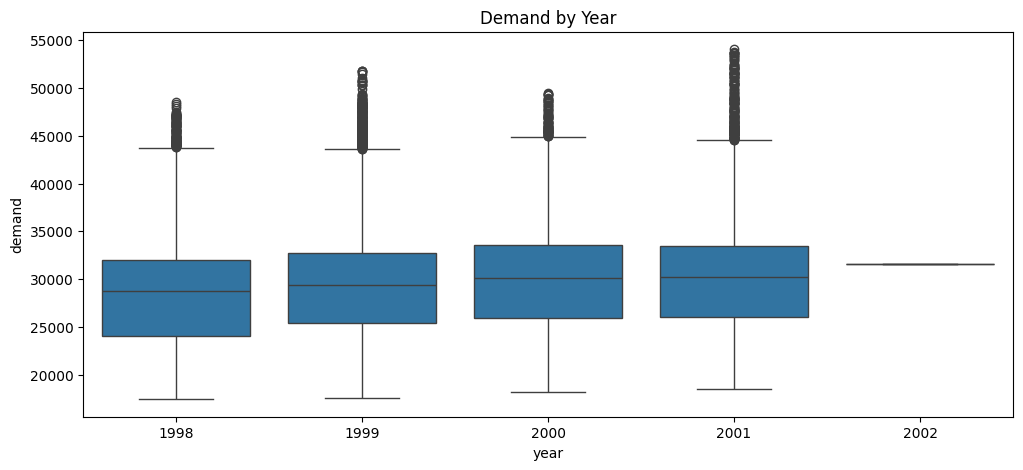

In [ ]:
plt.figure(figsize=(12,5))
sns.boxplot(x='year', y='demand', data=df)
plt.title('Demand by Year')
plt.savefig('./data/output/pjm_demand_byyear.png', dpi=300)
plt.show()

Conclusion - Median demand increases slightly every year (2002 has incomplete data), 1999 and 2001 has more spikes (outlier points higher than the median)

# Training

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32904 entries, 1998-04-01 01:00:00 to 2002-01-01 00:00:00
Freq: h
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   demand  32904 non-null  float64
dtypes: float64(1)
memory usage: 514.1 KB


## Generic Functions

### Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_forecast(y_true, y_pred,model_name=None,plot=True,train=None, test=None,forecast_mean=None, pred_ci=None,fold=None):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    print(f"\n--- Evaluation Results {f'for {model_name}' if model_name else ''} ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R²: {r2:.4f}")

    if plot:
        if all(v is not None for v in [forecast_mean, pred_ci]):
            plt.figure(figsize=(12, 5))

            plt.plot(test.index, test.values, label='Observed', color='black')
            plt.plot(forecast_mean.index, forecast_mean.values, label='Forecast', color='orange')
            plt.fill_between(
                pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1],
                color='gray', alpha=0.3, label='95% CI'
            )

            title = f"{model_name} Forecast vs Observed"
            if fold is not None:
                title += f" (Fold {fold})"
            plt.title(title)
            plt.xlabel("Time")
            plt.ylabel("Demand")
            plt.legend(loc='upper left')
            plt.tight_layout()
            plt.show()

        else:
            plt.figure(figsize=(10, 5))
            plt.plot(y_true, label='Actual', color='blue')
            plt.plot(y_pred, label='Predicted', color='orange')
            plt.title(f"Actual vs Predicted {f'({model_name})' if model_name else ''}")
            plt.xlabel("Time")
            plt.ylabel("Value")
            plt.legend()
            plt.tight_layout()
            plt.show()

    return { "rmse": rmse,"mae": mae,"mape": mape,"r2": r2}


### Plot Split

In [ ]:
from matplotlib.lines import Line2D
import matplotlib.cm as cm

def plot_splits(df, splits, strategy_name="Split Strategy"):
    cmap = cm.get_cmap('tab10', 2)  
    
    for i, (train, test) in enumerate(splits):
        plt.figure(figsize=(12, 4))
        
        plt.plot(df.index, df.values, color='lightgray', alpha=0.5)
        
        plt.plot(train.index, train.values, color=cmap(0), lw=1.5)
        
        plt.plot(test.index, test.values, color=cmap(1), lw=2, linestyle='--')
    
        legend_elements = [
            Line2D([0], [0], color='lightgray', lw=1.5, label='Full Series'),
            Line2D([0], [0], color=cmap(0), lw=1.5, label='Train'),
            Line2D([0], [0], color=cmap(1), lw=2, linestyle='--', label='Test')
        ]
        plt.legend(handles=legend_elements)
        
        plt.title(f"{strategy_name} - Fold {i+1}")
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.tight_layout()
        plt.show()


## Split

### Expanding Window

the idea of expanding set is we sequentially train and evaluate the model on more and more data  - this could help us determine how much training data we need or even help us breakdown the training task by snapshotting, evaluating and then adding on more data as we go or in the future

In [ ]:
df.isna().sum()

demand    0
dtype: int64

Fold 1: Train [1998-04-01 01:00:00–1998-07-30 00:00:00] (2880), Test [1998-07-30 01:00:00–1998-10-28 00:00:00] (2160)
Fold 2: Train [1998-04-01 01:00:00–1998-11-27 00:00:00] (5760), Test [1998-11-27 01:00:00–1999-02-25 00:00:00] (2160)
Fold 3: Train [1998-04-01 01:00:00–1999-03-27 00:00:00] (8640), Test [1999-03-27 01:00:00–1999-06-25 00:00:00] (2160)
Fold 4: Train [1998-04-01 01:00:00–1999-07-25 00:00:00] (11520), Test [1999-07-25 01:00:00–1999-10-23 00:00:00] (2160)
Fold 5: Train [1998-04-01 01:00:00–1999-11-22 00:00:00] (14400), Test [1999-11-22 01:00:00–2000-02-20 00:00:00] (2160)
Fold 6: Train [1998-04-01 01:00:00–2000-03-21 00:00:00] (17280), Test [2000-03-21 01:00:00–2000-06-19 00:00:00] (2160)
Fold 7: Train [1998-04-01 01:00:00–2000-07-19 00:00:00] (20160), Test [2000-07-19 01:00:00–2000-10-17 00:00:00] (2160)
Fold 8: Train [1998-04-01 01:00:00–2000-11-16 00:00:00] (23040), Test [2000-11-16 01:00:00–2001-02-14 00:00:00] (2160)
Fold 9: Train [1998-04-01 01:00:00–2001-03-16 00:00

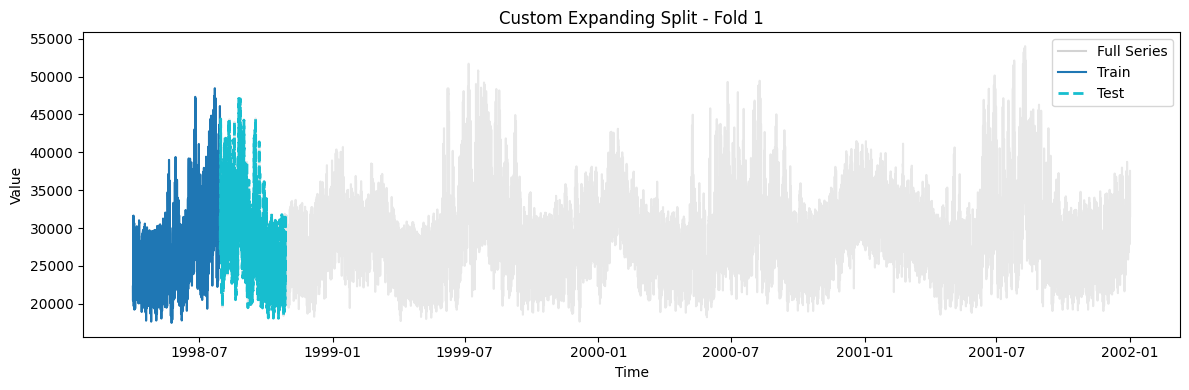

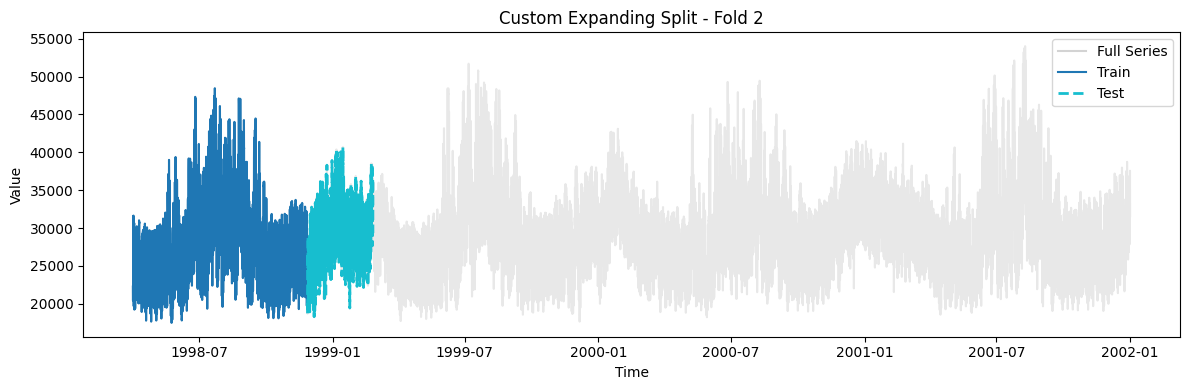

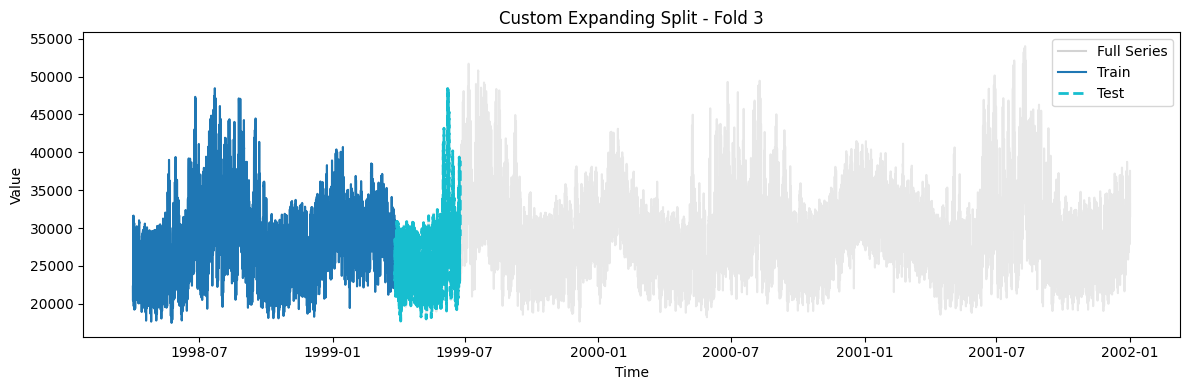

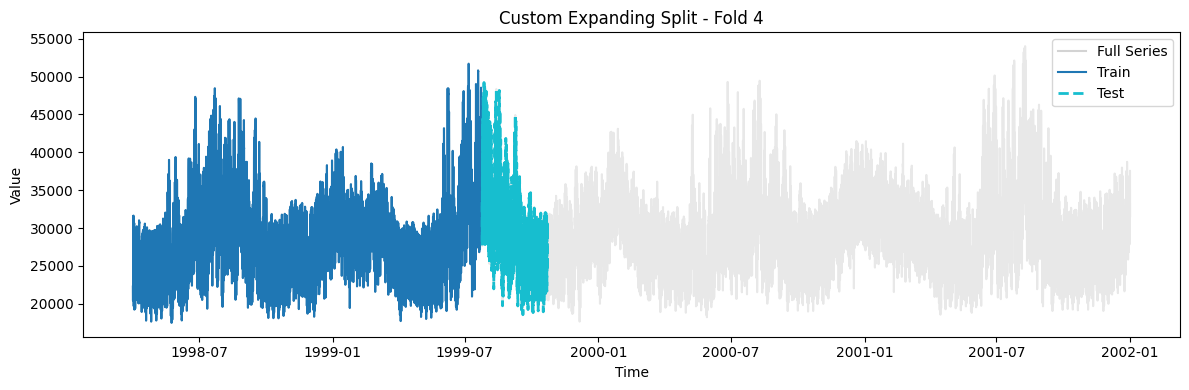

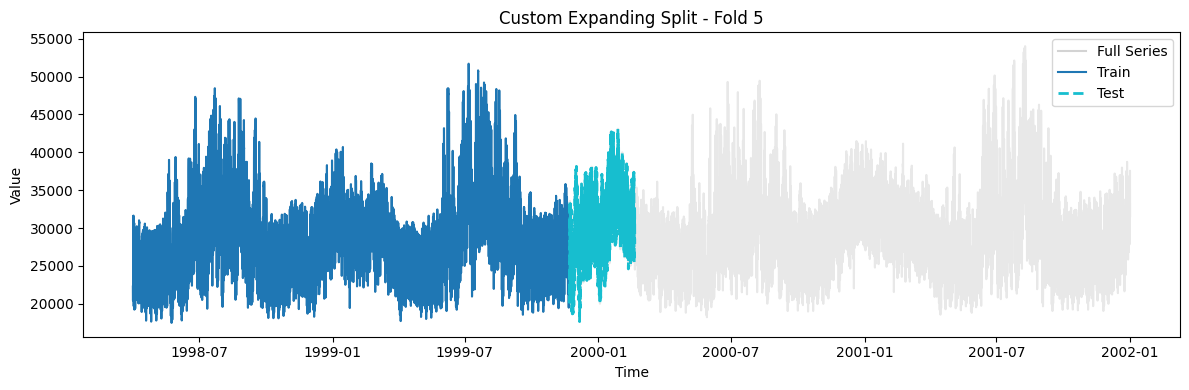

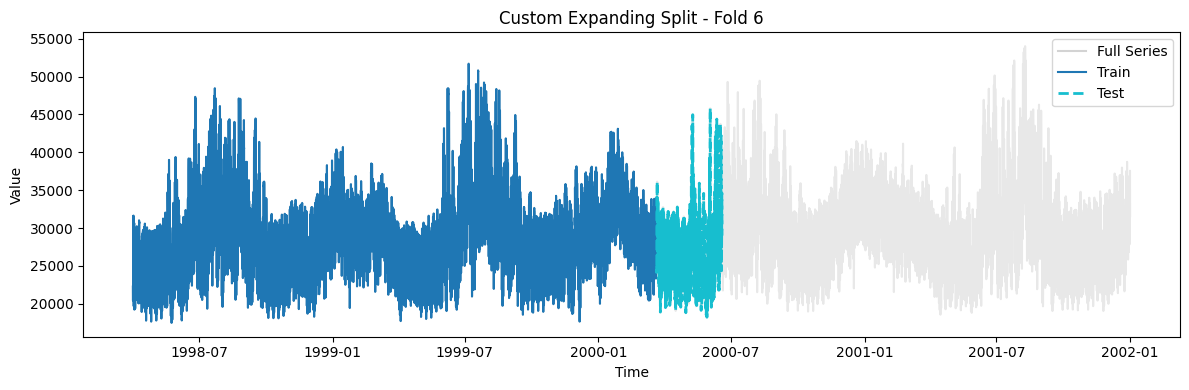

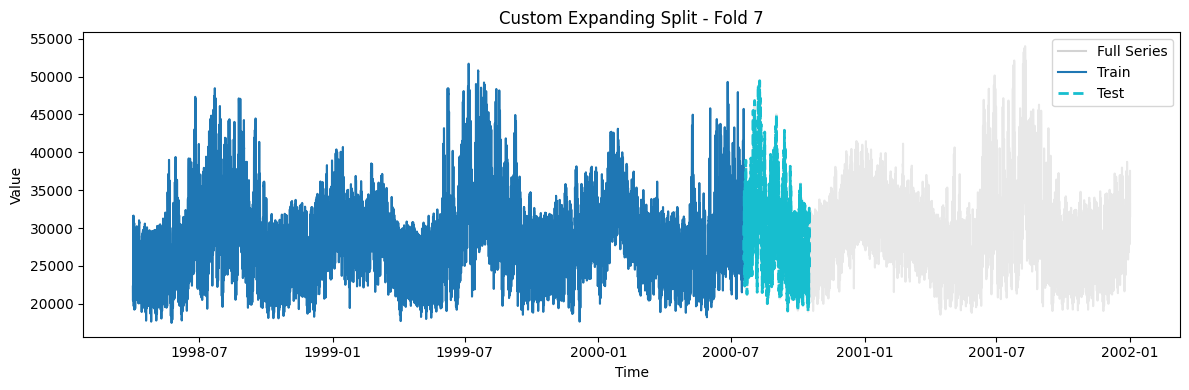

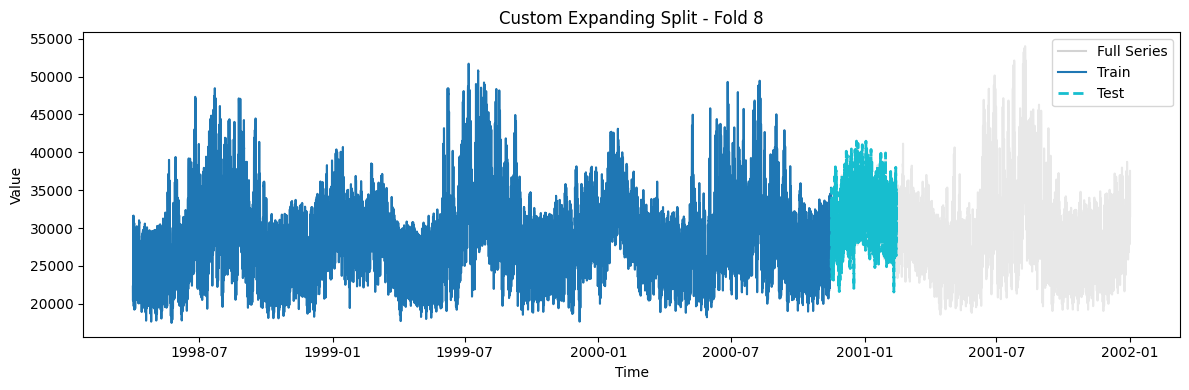

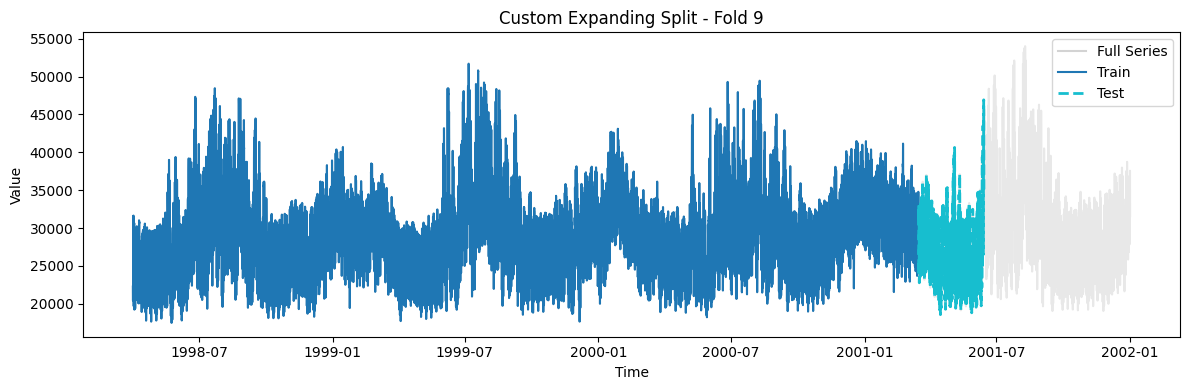

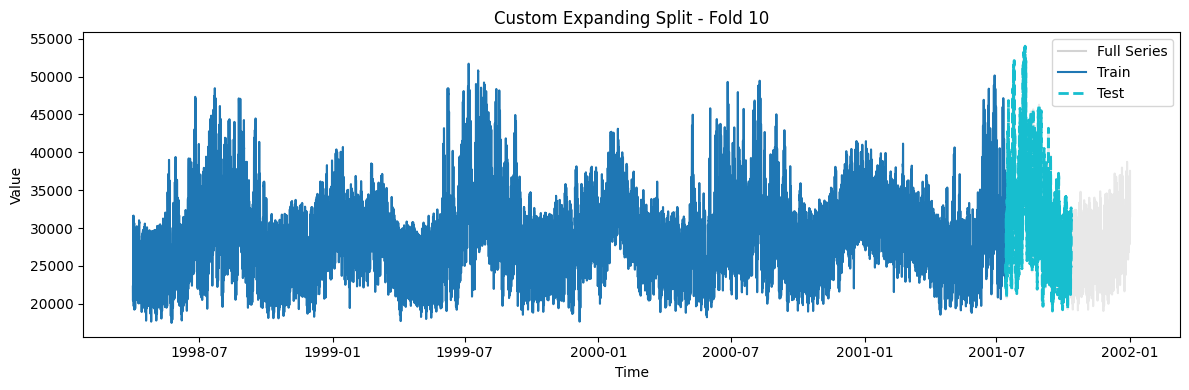

In [ ]:
def get_custom_expanding_splits(df, initial_train_size=24*30,test_size=24*7,max_train_size=None,step_size=24*7):           
    splits = []
    start = 0
    while True:
        end_train = start + initial_train_size
        end_test = end_train + test_size
        if end_test > len(df):
            break

        train = df.iloc[start:end_train]
        test = df.iloc[end_train:end_test]

        splits.append((train, test))
        print(f"Fold {len(splits)}: Train [{train.index[0]}–{train.index[-1]}] ({len(train)}), "
              f"Test [{test.index[0]}–{test.index[-1]}] ({len(test)})")

        if max_train_size is None:
            initial_train_size += step_size
        else:
            initial_train_size = min(initial_train_size + step_size, max_train_size)

    return splits


custom_expanding_window_splits = get_custom_expanding_splits(df, initial_train_size=24*120, test_size=24*90, max_train_size=24*365*4, step_size=24*120)
plot_splits(df['demand'], custom_expanding_window_splits, strategy_name="Custom Expanding Split")

## Models

### XGB

In [ ]:
def create_lag_features(df, lags=[1, 24, 168]):
    df = df.copy()
    for lag in lags:
        df[f'lag_{lag}'] = df['demand'].shift(lag)
    df = df.dropna()
    return df


In [ ]:
import xgboost as xgb

def train_xgboost_on_splits(splits, lags=[1, 24, 168], min_train_size=24*30, max_train_size=24*365):
    
    model_name = 'XGBoost'
    all_metrics = []

    os.makedirs(f'./data/output/models/{model_name}', exist_ok=True)

    for i, (train, test) in enumerate(splits):
        print(f"\n===== Fold {i+1} =====")
        print(f"Fold {i+1}: train size={len(train)}, test size={len(test)}")

        if len(train) < min_train_size:
            print(f"Skipping fold {i+1}: train size too small ({len(train)} < {min_train_size})")
            continue
        elif len(train) > max_train_size:
            print(f"Reducing train size to max {max_train_size} samples")
            train = train.iloc[-max_train_size:]

        # Create lag features
        train_fe = create_lag_features(train, lags)
        test_fe = create_lag_features(pd.concat([train.iloc[-max(lags):], test]), lags)

        X_train = train_fe.drop(columns='demand')
        y_train = train_fe['demand']

        X_test = test_fe.loc[test.index].drop(columns='demand')
        y_test = test_fe.loc[test.index]['demand']

        print(f"Training {model_name} model on fold {i+1}")
        start_train = time.time()
        model = xgb.XGBRegressor(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            objective='reg:squarederror',
            verbosity=0
        )
        model.fit(X_train, y_train)
        end_train = time.time()
        print(f"Training time: {end_train - start_train:.2f} seconds")

        # Save model
        model_path = f'./data/output/models/{model_name}/{model_name}_fold_{i+1}.pkl'
        with open(model_path, 'wb') as f:
            pickle.dump(model, f)
        print(f"Fold {i+1} model saved to {model_path}")

        # Forecast
        start_infer = time.time()
        y_pred = model.predict(X_test)
        end_infer = time.time()
        print(f"Inference time: {end_infer - start_infer:.2f} seconds")

        # Approximate confidence interval using residuals
        resid_std = np.std(y_train - model.predict(X_train))
        forecast_mean = pd.Series(y_pred, index=X_test.index)
        pred_ci = pd.DataFrame({
            'yhat_lower': forecast_mean - 1.96 * resid_std,
            'yhat_upper': forecast_mean + 1.96 * resid_std
        }, index=X_test.index)

        metrics = evaluate_forecast(
            y_true=y_test.values,
            y_pred=y_pred,
            model_name=f"{model_name} Fold {i+1}",
            plot=True, train=train, test=test,
            forecast_mean=forecast_mean, pred_ci=pred_ci, fold=i+1
        )
        all_metrics.append(metrics)

    avg_metrics = {k: np.mean([m[k] for m in all_metrics]) for k in all_metrics[0]}
    print("\n===== Average metrics across folds =====")
    for k, v in avg_metrics.items():
        print(f"{k.upper()}: {v:.4f}")

    return model, all_metrics, avg_metrics



===== Fold 1 =====
Fold 1: train size=2880, test size=2160
Training XGBoost model on fold 1
Training time: 0.35 seconds
Fold 1 model saved to ./data/output/models/XGBoost/XGBoost_fold_1.pkl
Inference time: 0.01 seconds

--- Evaluation Results for XGBoost Fold 1 ---
RMSE: 1297.2268
MAE: 962.1960
MAPE: 3.31%
R²: 0.9585


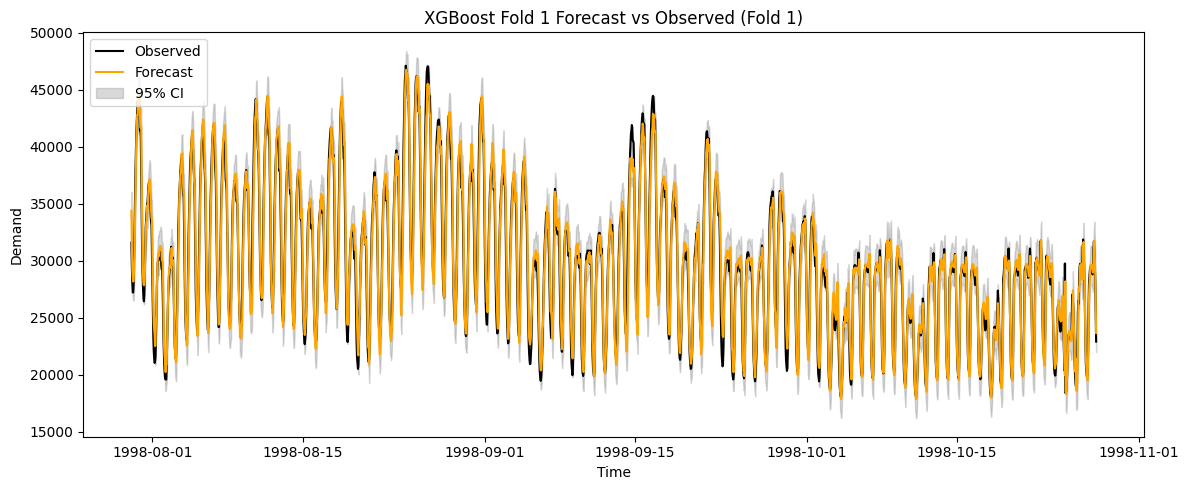


===== Fold 2 =====
Fold 2: train size=5760, test size=2160
Training XGBoost model on fold 2
Training time: 0.53 seconds
Fold 2 model saved to ./data/output/models/XGBoost/XGBoost_fold_2.pkl
Inference time: 0.01 seconds

--- Evaluation Results for XGBoost Fold 2 ---
RMSE: 1234.7003
MAE: 947.4160
MAPE: 3.24%
R²: 0.9203


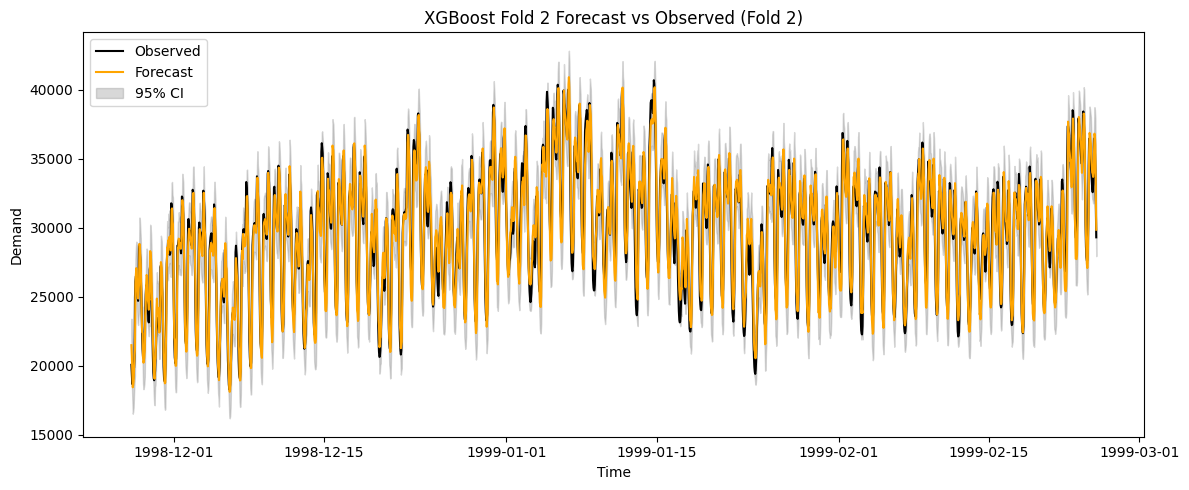


===== Fold 3 =====
Fold 3: train size=8640, test size=2160
Training XGBoost model on fold 3
Training time: 0.19 seconds
Fold 3 model saved to ./data/output/models/XGBoost/XGBoost_fold_3.pkl
Inference time: 0.00 seconds

--- Evaluation Results for XGBoost Fold 3 ---
RMSE: 1034.2084
MAE: 738.8970
MAPE: 2.75%
R²: 0.9603


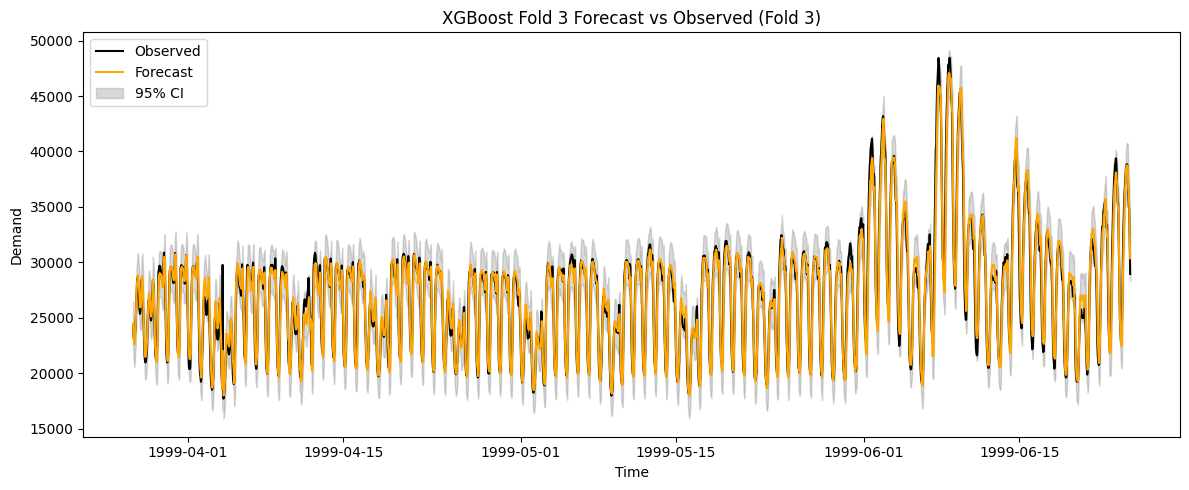


===== Fold 4 =====
Fold 4: train size=11520, test size=2160
Reducing train size to max 8760 samples
Training XGBoost model on fold 4
Training time: 0.26 seconds
Fold 4 model saved to ./data/output/models/XGBoost/XGBoost_fold_4.pkl
Inference time: 0.00 seconds

--- Evaluation Results for XGBoost Fold 4 ---
RMSE: 1262.1088
MAE: 963.4533
MAPE: 3.19%
R²: 0.9651


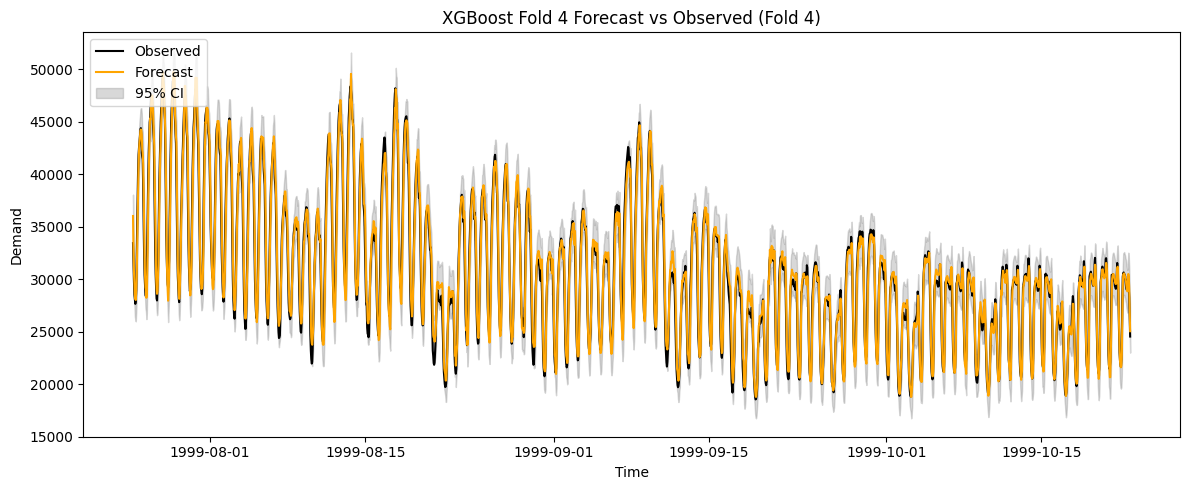


===== Fold 5 =====
Fold 5: train size=14400, test size=2160
Reducing train size to max 8760 samples
Training XGBoost model on fold 5
Training time: 0.18 seconds
Fold 5 model saved to ./data/output/models/XGBoost/XGBoost_fold_5.pkl
Inference time: 0.01 seconds

--- Evaluation Results for XGBoost Fold 5 ---
RMSE: 1256.3540
MAE: 963.0588
MAPE: 3.20%
R²: 0.9298


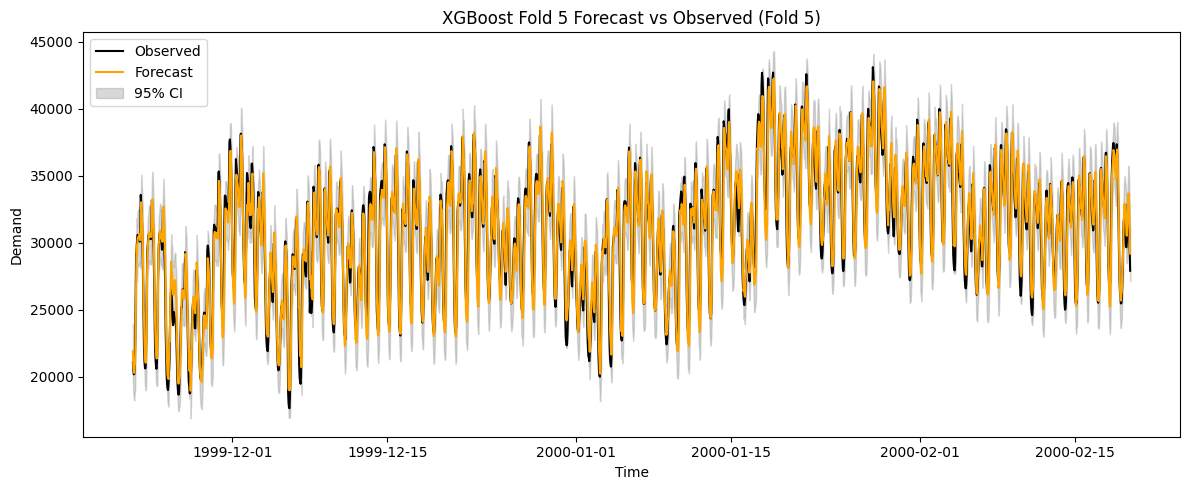


===== Fold 6 =====
Fold 6: train size=17280, test size=2160
Reducing train size to max 8760 samples
Training XGBoost model on fold 6
Training time: 0.23 seconds
Fold 6 model saved to ./data/output/models/XGBoost/XGBoost_fold_6.pkl
Inference time: 0.01 seconds

--- Evaluation Results for XGBoost Fold 6 ---
RMSE: 1186.6026
MAE: 877.4995
MAPE: 3.16%
R²: 0.9492


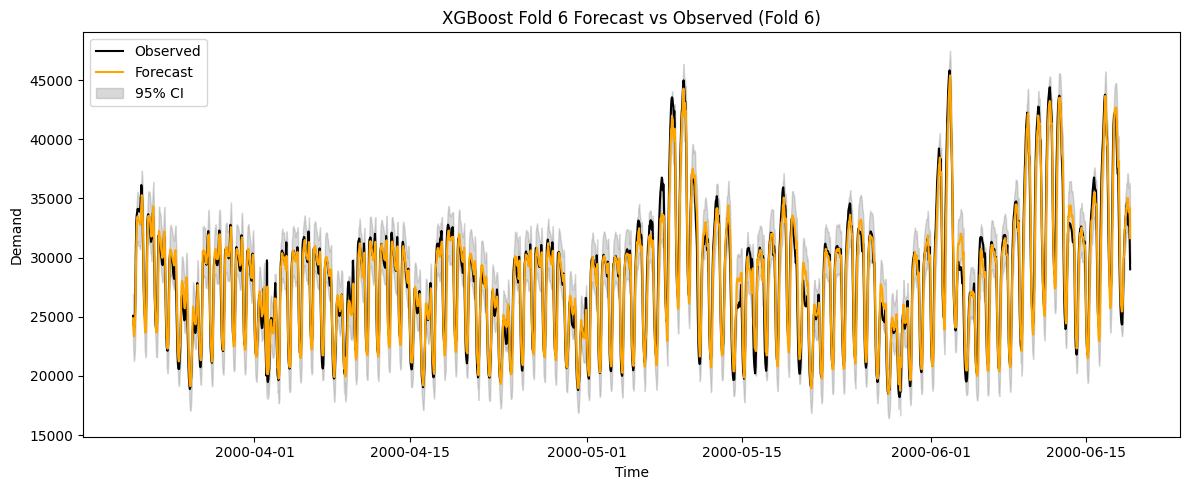


===== Fold 7 =====
Fold 7: train size=20160, test size=2160
Reducing train size to max 8760 samples
Training XGBoost model on fold 7
Training time: 0.21 seconds
Fold 7 model saved to ./data/output/models/XGBoost/XGBoost_fold_7.pkl
Inference time: 0.01 seconds

--- Evaluation Results for XGBoost Fold 7 ---
RMSE: 1233.9284
MAE: 958.2817
MAPE: 3.21%
R²: 0.9600


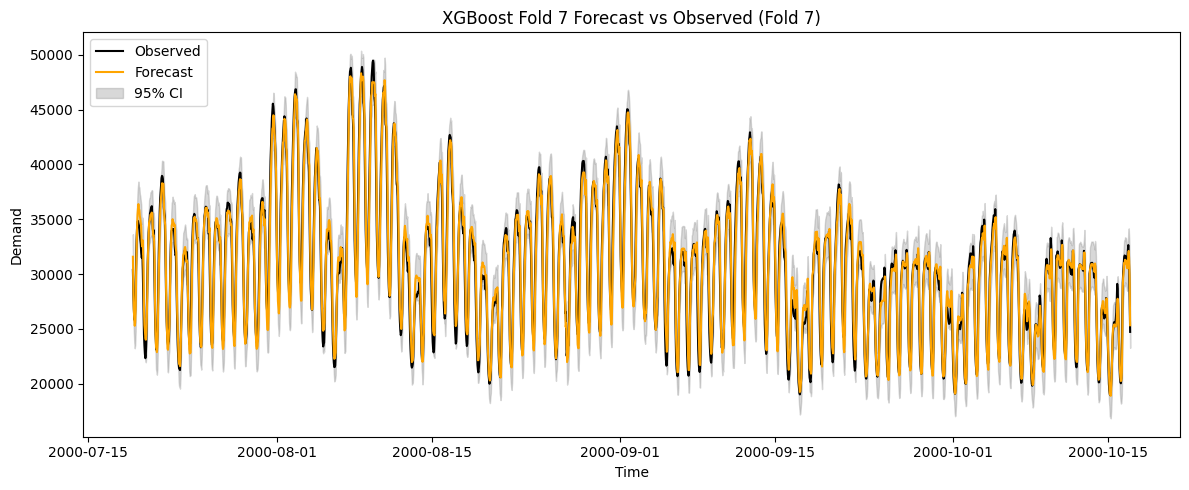


===== Fold 8 =====
Fold 8: train size=23040, test size=2160
Reducing train size to max 8760 samples
Training XGBoost model on fold 8
Training time: 0.24 seconds
Fold 8 model saved to ./data/output/models/XGBoost/XGBoost_fold_8.pkl
Inference time: 0.01 seconds

--- Evaluation Results for XGBoost Fold 8 ---
RMSE: 1207.9256
MAE: 915.5771
MAPE: 2.87%
R²: 0.9078


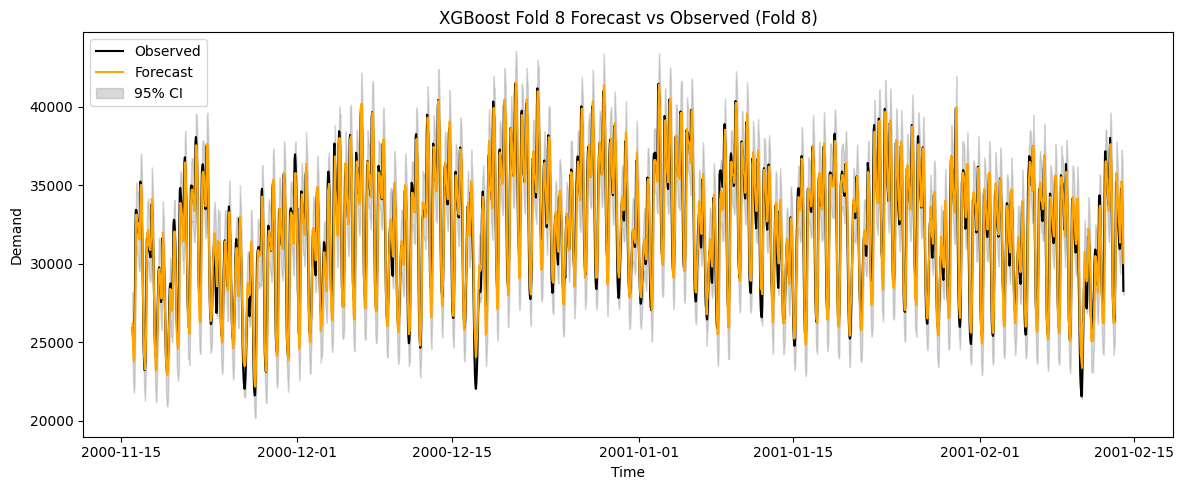


===== Fold 9 =====
Fold 9: train size=25920, test size=2160
Reducing train size to max 8760 samples
Training XGBoost model on fold 9
Training time: 0.22 seconds
Fold 9 model saved to ./data/output/models/XGBoost/XGBoost_fold_9.pkl
Inference time: 0.01 seconds

--- Evaluation Results for XGBoost Fold 9 ---
RMSE: 1008.0620
MAE: 772.0400
MAPE: 2.80%
R²: 0.9535


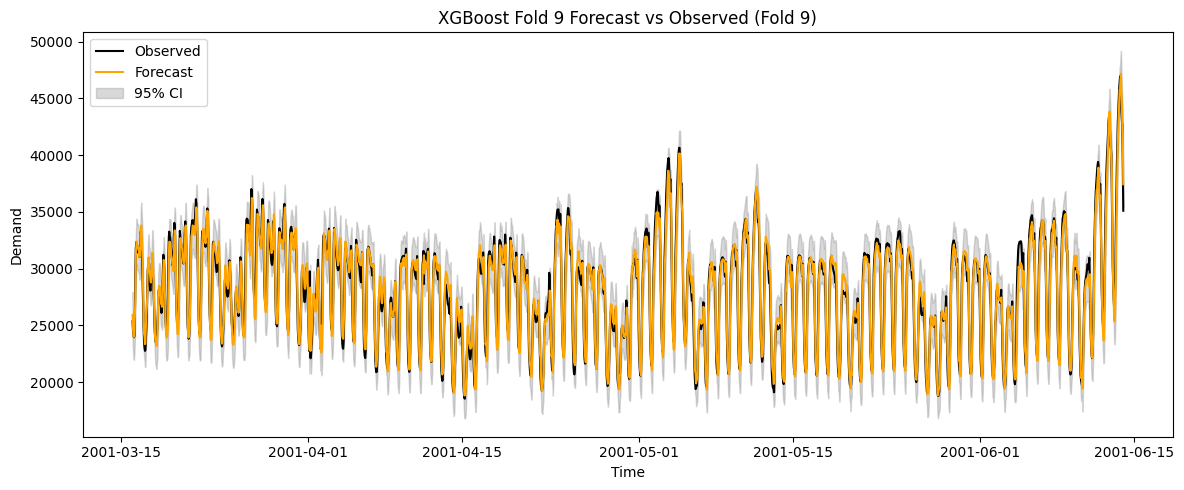


===== Fold 10 =====
Fold 10: train size=28800, test size=2160
Reducing train size to max 8760 samples
Training XGBoost model on fold 10
Training time: 0.20 seconds
Fold 10 model saved to ./data/output/models/XGBoost/XGBoost_fold_10.pkl
Inference time: 0.01 seconds

--- Evaluation Results for XGBoost Fold 10 ---
RMSE: 1517.0420
MAE: 1151.2489
MAPE: 3.58%
R²: 0.9572


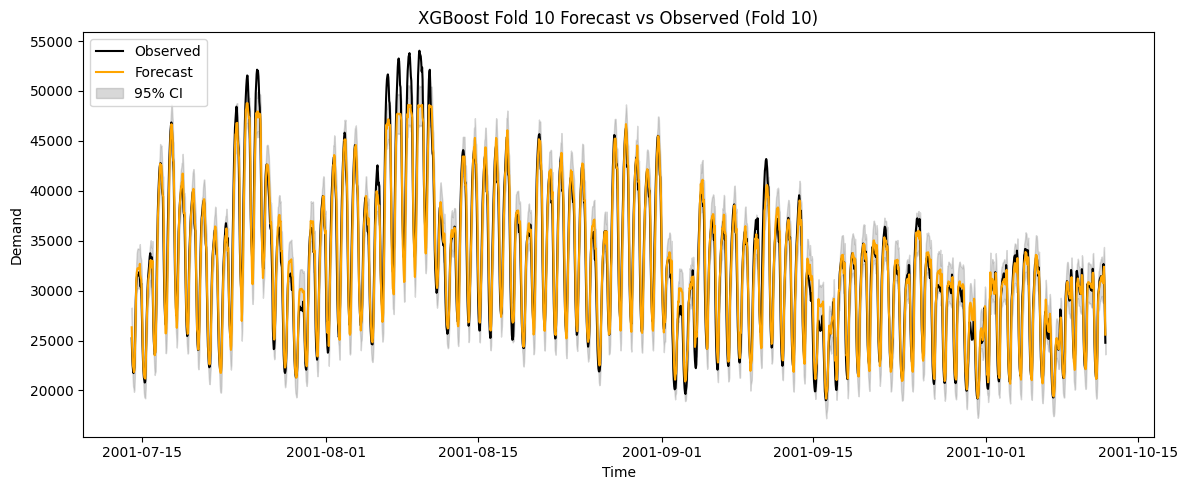


===== Average metrics across folds =====
RMSE: 1223.8159
MAE: 924.9668
MAPE: 3.1303
R2: 0.9462


In [ ]:
xgb_model, xgb_all_metrics, xgb_avg_metrics = train_xgboost_on_splits(
    splits= custom_expanding_window_splits,
    lags=[1, 24, 168],
    min_train_size=24*30,
    max_train_size=24*365
)

### LightGBM

In [ ]:
import lightgbm as lgb

def train_lightgbm_on_splits(splits, lags=[1, 24, 168], min_train_size=24*30, max_train_size=24*365):
    
    model_name = 'lightgbm'
    all_metrics = []

    os.makedirs(f'./data/output/models/{model_name}', exist_ok=True)

    for i, (train, test) in enumerate(splits):
        print(f"\n===== Fold {i+1} =====")
        print(f"Fold {i+1}: train size={len(train)}, test size={len(test)}")

        if len(train) < min_train_size:
            print(f"Skipping fold {i+1}: train size too small ({len(train)} < {min_train_size})")
            continue
        elif len(train) > max_train_size:
            print(f"Reducing train size to max {max_train_size} samples")
            train = train.iloc[-max_train_size:]

        # Create lag features
        train_fe = create_lag_features(train, lags)
        test_fe = create_lag_features(pd.concat([train.iloc[-max(lags):], test]), lags)

        X_train = train_fe.drop(columns='demand')
        y_train = train_fe['demand']

        X_test = test_fe.loc[test.index].drop(columns='demand')
        y_test = test_fe.loc[test.index]['demand']

        print(f"Training {model_name} model on fold {i+1}")
        start_train = time.time()
        model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05)
        # xgb.XGBRegressor(
        #     n_estimators=100,
        #     max_depth=5,
        #     learning_rate=0.1,
        #     objective='reg:squarederror',
        #     verbosity=0
        # )
        model.fit(X_train, y_train)
        end_train = time.time()
        print(f"Training time: {end_train - start_train:.2f} seconds")

        # Save model
        model_path = f'./data/output/models/{model_name}/{model_name}_fold_{i+1}.pkl'
        with open(model_path, 'wb') as f:
            pickle.dump(model, f)
        print(f"Fold {i+1} model saved to {model_path}")

        # Forecast
        start_infer = time.time()
        y_pred = model.predict(X_test)
        end_infer = time.time()
        print(f"Inference time: {end_infer - start_infer:.2f} seconds")

        # Approximate confidence interval using residuals
        resid_std = np.std(y_train - model.predict(X_train))
        forecast_mean = pd.Series(y_pred, index=X_test.index)
        pred_ci = pd.DataFrame({
            'yhat_lower': forecast_mean - 1.96 * resid_std,
            'yhat_upper': forecast_mean + 1.96 * resid_std
        }, index=X_test.index)

        metrics = evaluate_forecast(
            y_true=y_test.values,
            y_pred=y_pred,
            model_name=f"{model_name} Fold {i+1}",
            plot=True, train=train, test=test,
            forecast_mean=forecast_mean, pred_ci=pred_ci, fold=i+1
        )
        all_metrics.append(metrics)

    avg_metrics = {k: np.mean([m[k] for m in all_metrics]) for k in all_metrics[0]}
    print("\n===== Average metrics across folds =====")
    for k, v in avg_metrics.items():
        print(f"{k.upper()}: {v:.4f}")

    return model, all_metrics, avg_metrics



===== Fold 1 =====
Fold 1: train size=2880, test size=2160
Training lightgbm model on fold 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 2712, number of used features: 3
[LightGBM] [Info] Start training from score 28787.005531
Training time: 18.88 seconds
Fold 1 model saved to ./data/output/models/lightgbm/lightgbm_fold_1.pkl
Inference time: 0.08 seconds

--- Evaluation Results for lightgbm Fold 1 ---
RMSE: 1382.1413
MAE: 1044.4008
MAPE: 3.57%
R²: 0.9529


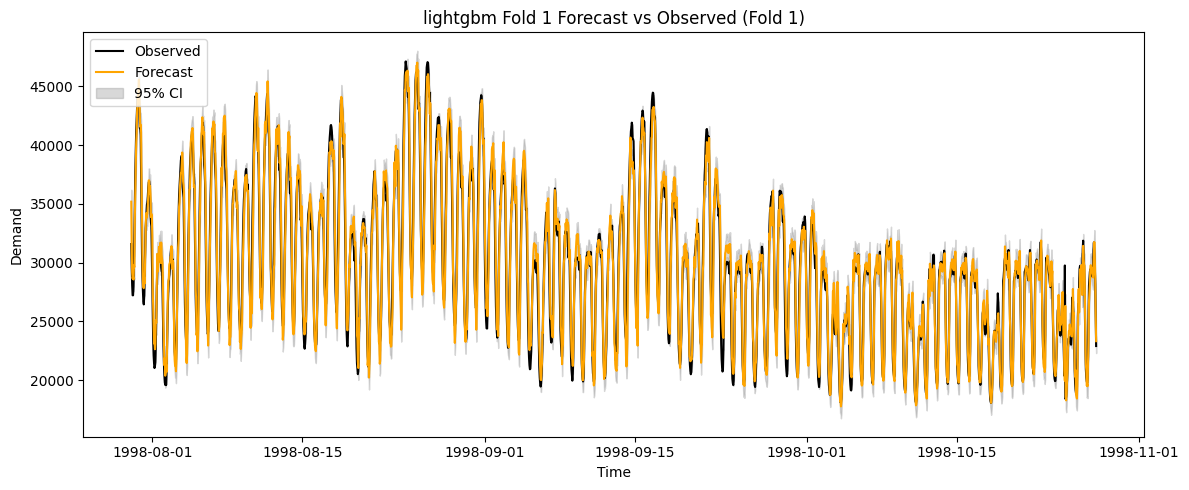


===== Fold 2 =====
Fold 2: train size=5760, test size=2160
Training lightgbm model on fold 2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5592, number of used features: 3
[LightGBM] [Info] Start training from score 28935.468782
Training time: 1.46 seconds
Fold 2 model saved to ./data/output/models/lightgbm/lightgbm_fold_2.pkl
Inference time: 0.09 seconds

--- Evaluation Results for lightgbm Fold 2 ---
RMSE: 1323.2815
MAE: 1015.7340
MAPE: 3.46%
R²: 0.9084


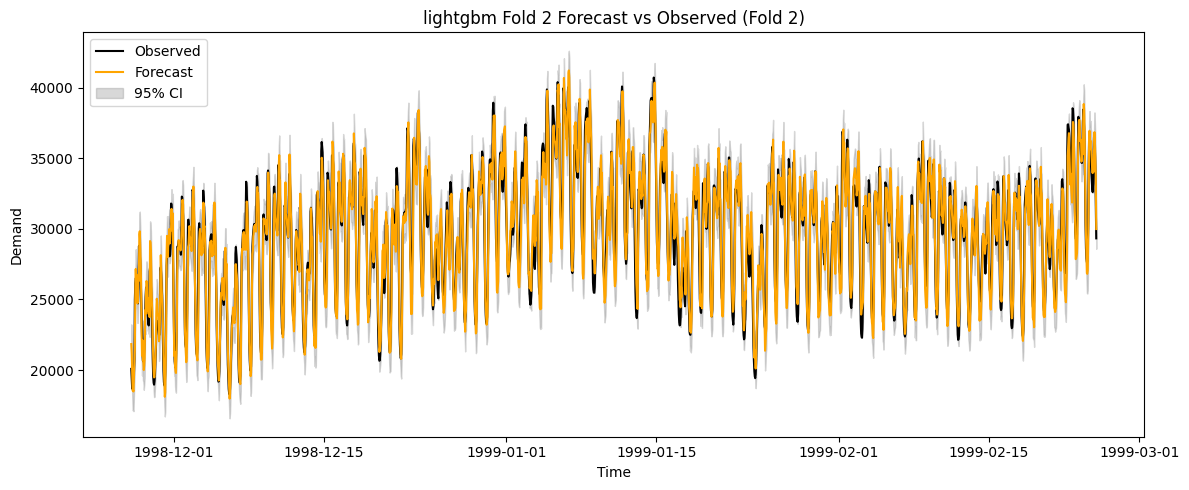


===== Fold 3 =====
Fold 3: train size=8640, test size=2160
Training lightgbm model on fold 3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 8472, number of used features: 3
[LightGBM] [Info] Start training from score 29113.701538
Training time: 0.89 seconds
Fold 3 model saved to ./data/output/models/lightgbm/lightgbm_fold_3.pkl
Inference time: 0.07 seconds

--- Evaluation Results for lightgbm Fold 3 ---
RMSE: 1080.1953
MAE: 760.1139
MAPE: 2.82%
R²: 0.9567


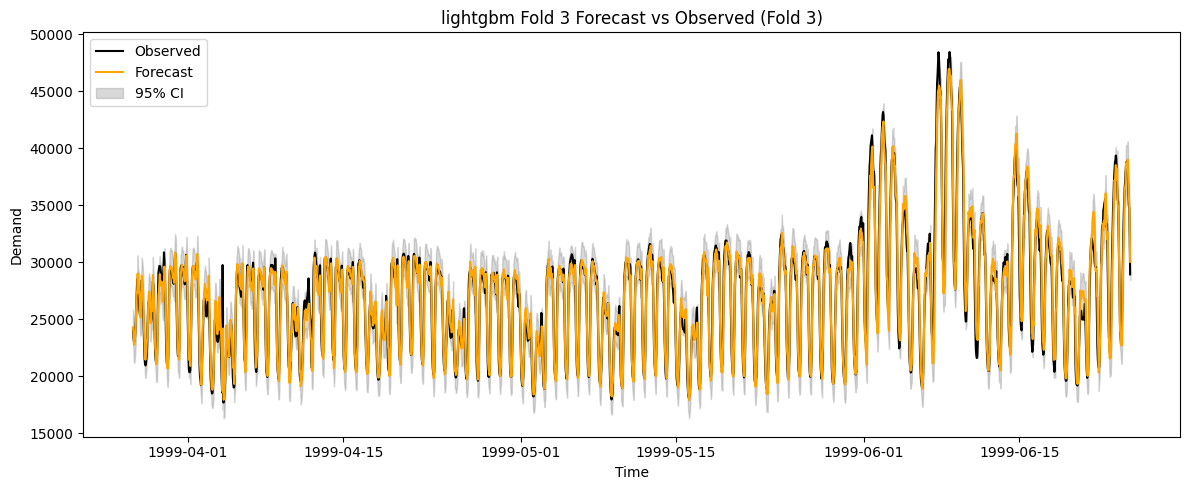


===== Fold 4 =====
Fold 4: train size=11520, test size=2160
Reducing train size to max 8760 samples
Training lightgbm model on fold 4
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 8592, number of used features: 3
[LightGBM] [Info] Start training from score 29262.318652
Training time: 1.59 seconds
Fold 4 model saved to ./data/output/models/lightgbm/lightgbm_fold_4.pkl
Inference time: 0.15 seconds

--- Evaluation Results for lightgbm Fold 4 ---
RMSE: 1317.7837
MAE: 1007.3975
MAPE: 3.33%
R²: 0.9619


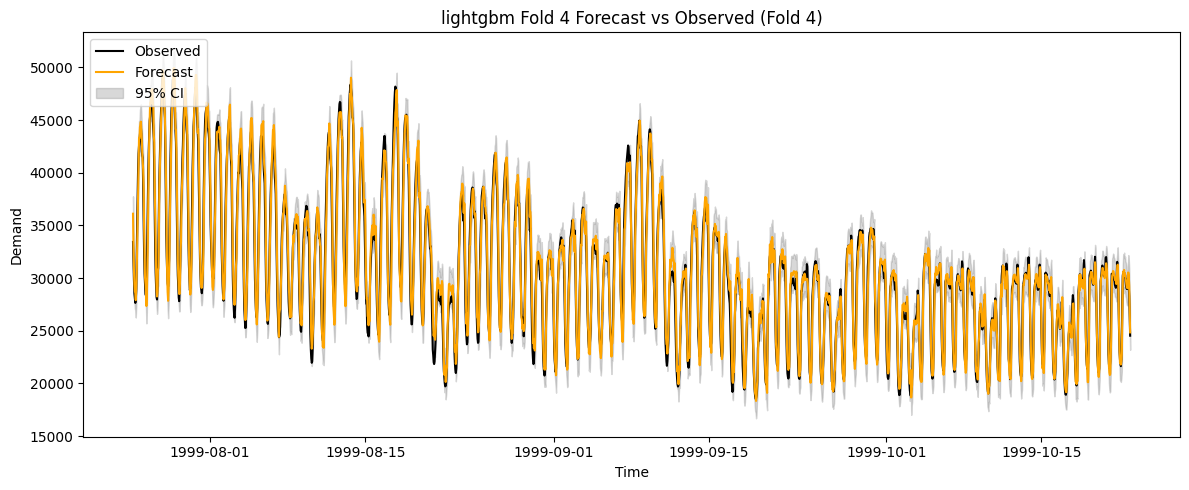


===== Fold 5 =====
Fold 5: train size=14400, test size=2160
Reducing train size to max 8760 samples
Training lightgbm model on fold 5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 8592, number of used features: 3
[LightGBM] [Info] Start training from score 29582.570281
Training time: 1.19 seconds
Fold 5 model saved to ./data/output/models/lightgbm/lightgbm_fold_5.pkl
Inference time: 0.07 seconds

--- Evaluation Results for lightgbm Fold 5 ---
RMSE: 1332.7067
MAE: 1029.7756
MAPE: 3.40%
R²: 0.9210


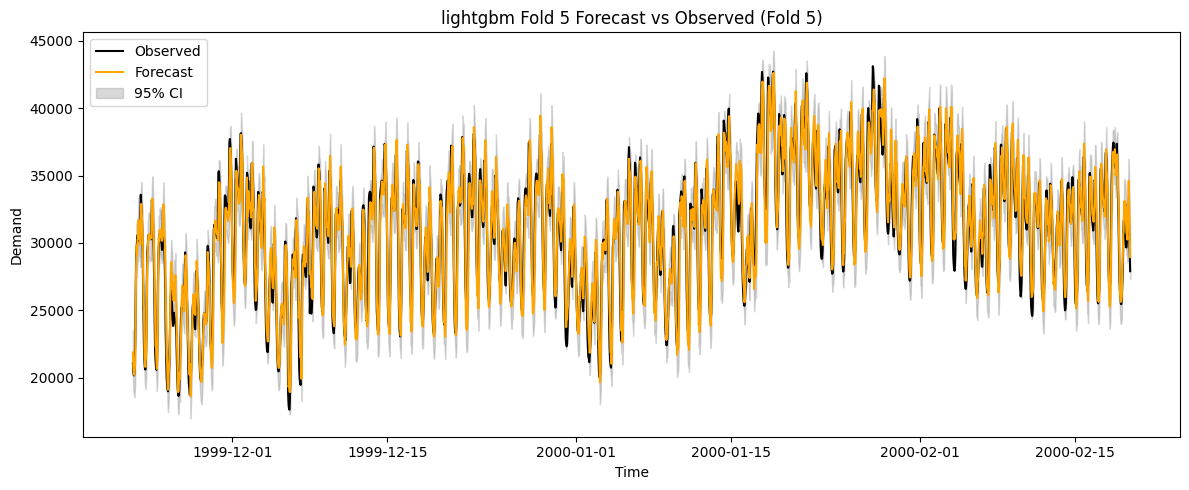


===== Fold 6 =====
Fold 6: train size=17280, test size=2160
Reducing train size to max 8760 samples
Training lightgbm model on fold 6
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 8592, number of used features: 3
[LightGBM] [Info] Start training from score 29828.519769
Training time: 2.48 seconds
Fold 6 model saved to ./data/output/models/lightgbm/lightgbm_fold_6.pkl
Inference time: 0.08 seconds

--- Evaluation Results for lightgbm Fold 6 ---
RMSE: 1218.6401
MAE: 898.0893
MAPE: 3.24%
R²: 0.9464


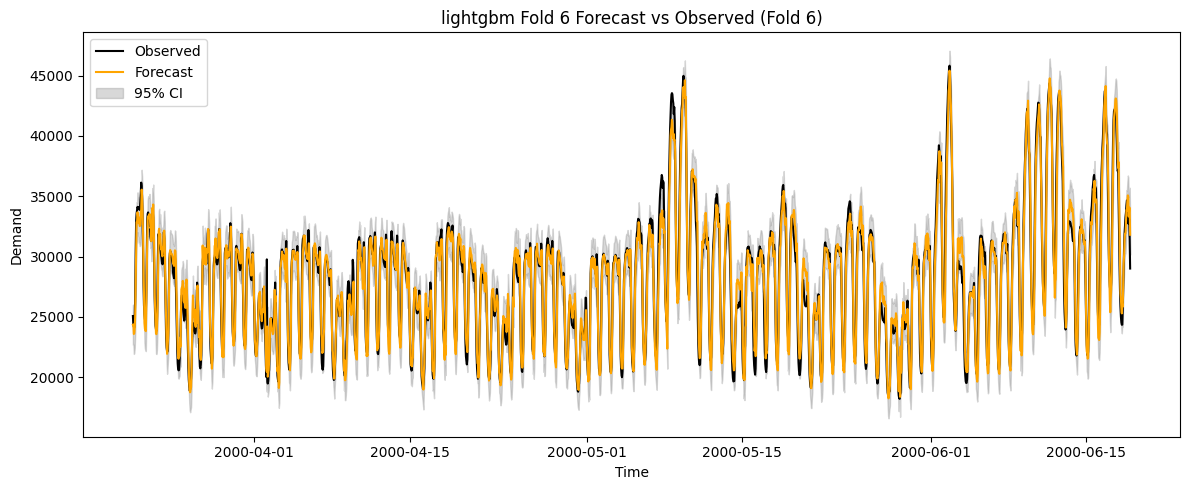


===== Fold 7 =====
Fold 7: train size=20160, test size=2160
Reducing train size to max 8760 samples
Training lightgbm model on fold 7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 8592, number of used features: 3
[LightGBM] [Info] Start training from score 29740.924913
Training time: 1.38 seconds
Fold 7 model saved to ./data/output/models/lightgbm/lightgbm_fold_7.pkl
Inference time: 0.07 seconds

--- Evaluation Results for lightgbm Fold 7 ---
RMSE: 1289.5631
MAE: 995.6508
MAPE: 3.34%
R²: 0.9563


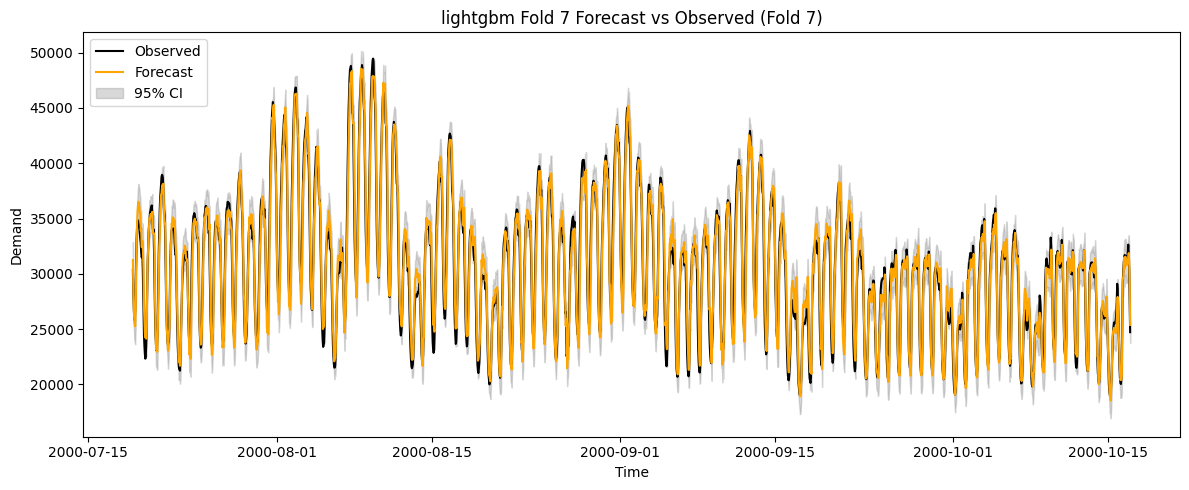


===== Fold 8 =====
Fold 8: train size=23040, test size=2160
Reducing train size to max 8760 samples
Training lightgbm model on fold 8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 8592, number of used features: 3
[LightGBM] [Info] Start training from score 29777.469141
Training time: 1.34 seconds
Fold 8 model saved to ./data/output/models/lightgbm/lightgbm_fold_8.pkl
Inference time: 0.07 seconds

--- Evaluation Results for lightgbm Fold 8 ---
RMSE: 1243.8911
MAE: 941.0237
MAPE: 2.95%
R²: 0.9022


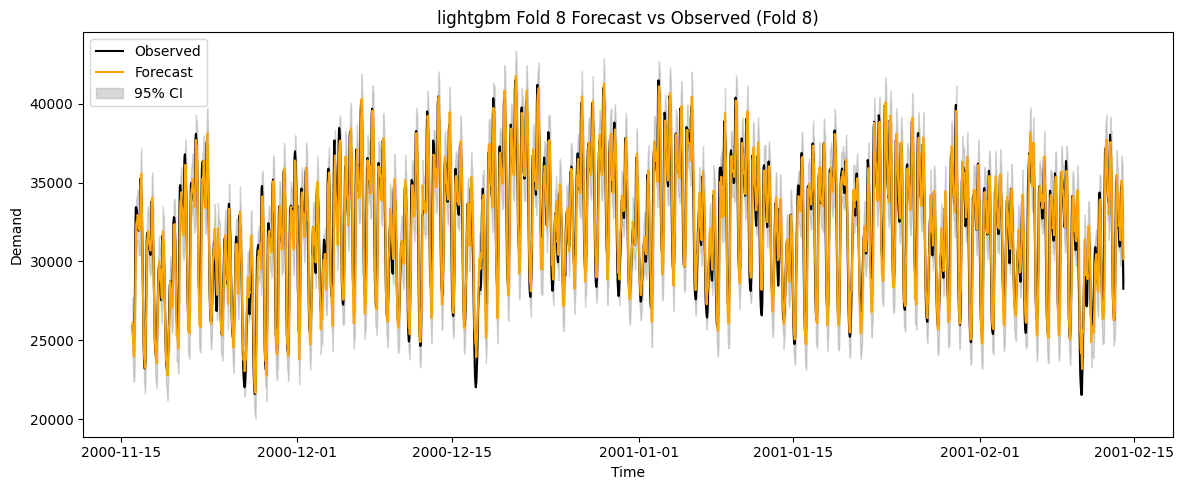


===== Fold 9 =====
Fold 9: train size=25920, test size=2160
Reducing train size to max 8760 samples
Training lightgbm model on fold 9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 8592, number of used features: 3
[LightGBM] [Info] Start training from score 30284.649657
Training time: 1.11 seconds
Fold 9 model saved to ./data/output/models/lightgbm/lightgbm_fold_9.pkl
Inference time: 0.06 seconds

--- Evaluation Results for lightgbm Fold 9 ---
RMSE: 1019.7997
MAE: 774.1825
MAPE: 2.80%
R²: 0.9524


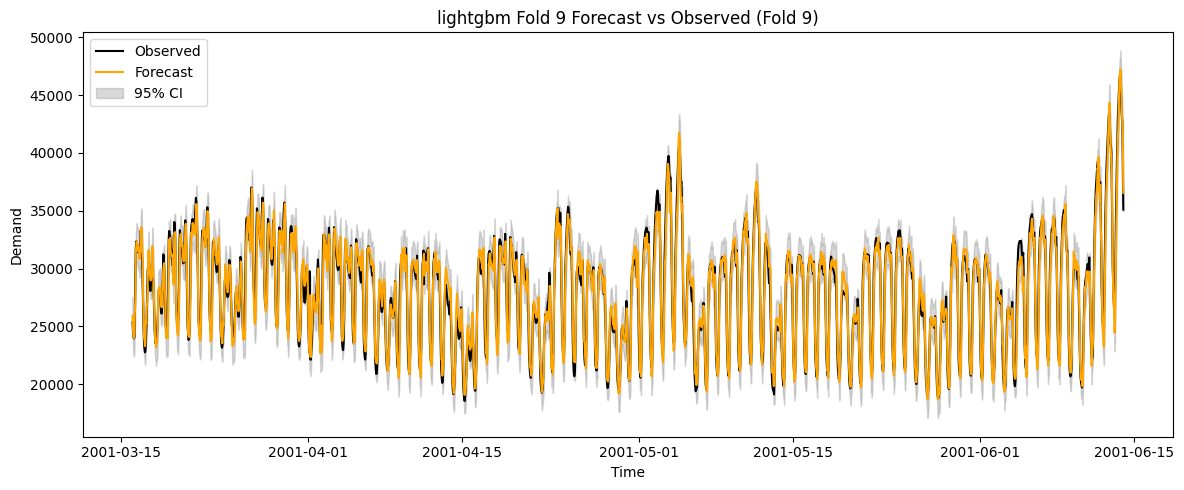


===== Fold 10 =====
Fold 10: train size=28800, test size=2160
Reducing train size to max 8760 samples
Training lightgbm model on fold 10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 8592, number of used features: 3
[LightGBM] [Info] Start training from score 30337.178172
Training time: 0.98 seconds
Fold 10 model saved to ./data/output/models/lightgbm/lightgbm_fold_10.pkl
Inference time: 0.07 seconds

--- Evaluation Results for lightgbm Fold 10 ---
RMSE: 1545.0301
MAE: 1178.7728
MAPE: 3.66%
R²: 0.9556


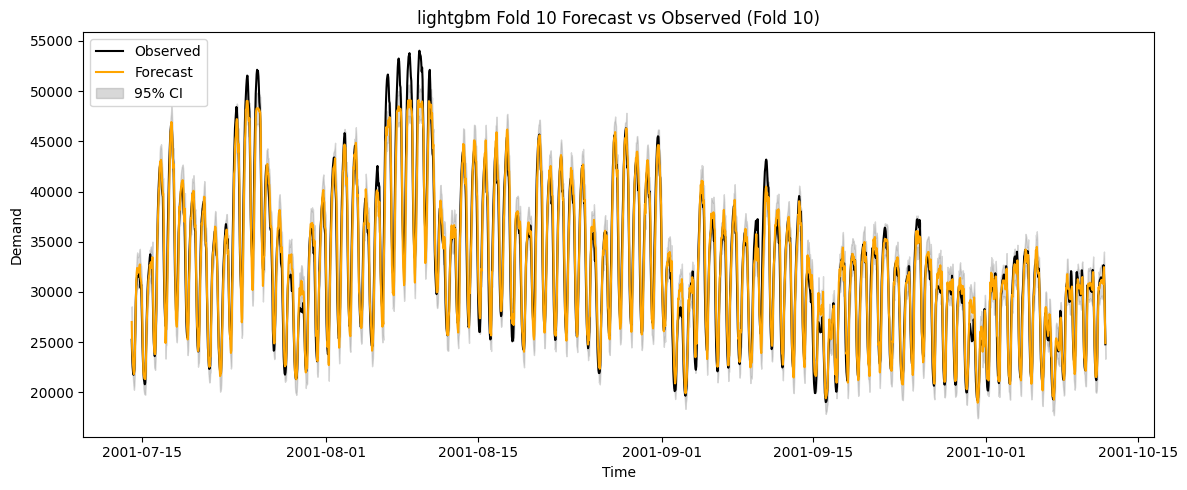


===== Average metrics across folds =====
RMSE: 1275.3033
MAE: 964.5141
MAPE: 3.2576
R2: 0.9414


In [ ]:
lightgbm_model, lightgbm_all_metrics, lightgbm_avg_metrics = train_lightgbm_on_splits(
    splits= custom_expanding_window_splits,
    lags=[1, 24, 168],
    min_train_size=24*30,
    max_train_size=24*365
)

### LSTM

In [ ]:
import numpy as np

def create_lstm_sequences(data, n_lags=24):
    X, y = [], []
    values = data['demand'].values
    for i in range(n_lags, len(values)):
        X.append(values[i - n_lags:i])  
        y.append(values[i])
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))  
    return X, y


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from joblib import dump

def build_lstm_model(n_lags, n_units=50):
    model = Sequential([
        LSTM(n_units, activation='tanh', input_shape=(n_lags, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
def train_lstm_on_splits(splits, n_lags=24, min_train_size=24*30, max_train_size=24*365, epochs=10, batch_size=32):
    model_name = 'LSTM'
    all_metrics = []

    os.makedirs(f'./data/output/models/{model_name}', exist_ok=True)

    scaler = MinMaxScaler(feature_range=(0, 1))

    for i, (train, test) in enumerate(splits):
        print(f"===== Fold {i+1} =====")
        print(f"Fold {i+1}: train size={len(train)}, test size={len(test)}")

        if len(train) < min_train_size:
            print(f"Skipping fold {i+1}: train size too small")
            continue
        elif len(train) > max_train_size:
            print(f"Reducing train size to max {max_train_size} samples")
            train = train.iloc[-max_train_size:]

        # Scale data
        scaled_train = scaler.fit_transform(train[['demand']])
        scaled_test = scaler.transform(test[['demand']])
        scaler_path = f'./data/output/models/{model_name}/{model_name}_fold_{i+1}_scaler.pkl'
        dump(scaler, scaler_path)

        # Create sequences
        X_train, y_train = create_lstm_sequences(pd.DataFrame(scaled_train, index=train.index, columns=['demand']), n_lags)
        
        extended_index = train.index[-n_lags:].append(test.index)
        extended_scaled = np.vstack([scaled_train[-n_lags:], scaled_test])

        df_test_seq = pd.DataFrame(extended_scaled, index=extended_index, columns=['demand'])
        X_test, y_test = create_lstm_sequences(df_test_seq, n_lags)

        valid_idx = test.index  
        y_test = y_test[-len(test):]
        X_test = X_test[-len(test):]

        print(f"Training {model_name} on fold {i+1}")
        model = build_lstm_model(n_lags)

        start_train = time.time()
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        end_train = time.time()
        print(f"Training time: {end_train - start_train:.2f} seconds")

        # Save model
        model_path = f'./data/output/models/{model_name}/{model_name}_fold_{i+1}.h5'
        model.save(model_path)
        print(f"Fold {i+1} model saved to {model_path}")

        # Forecast
        start_infer = time.time()
        y_pred_scaled = model.predict(X_test, verbose=0).flatten()
        end_infer = time.time()
        print(f"Inference time: {end_infer - start_infer:.2f} seconds")

        # Inverse scaling
        y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
        y_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

        # Forecast series
        # forecast_index = test.index[n_lags:]
        forecast_index = test.index
        forecast_mean = pd.Series(y_pred, index=forecast_index)

        # Approximate CI (±1.96 * std of residuals)
        resid_std = np.std(y_true - y_pred)
        pred_ci = pd.DataFrame({
            'yhat_lower': forecast_mean - 1.96 * resid_std,
            'yhat_upper': forecast_mean + 1.96 * resid_std
        }, index=forecast_index)

        metrics = evaluate_forecast(
            y_true=y_true,
            y_pred=y_pred,
            model_name=f"{model_name} Fold {i+1}",
            plot=True, train=train, test=test,
            forecast_mean=forecast_mean, pred_ci=pred_ci, fold=i+1
        )
        all_metrics.append(metrics)

    # Average metrics
    avg_metrics = {k: np.mean([m[k] for m in all_metrics]) for k in all_metrics[0]}
    print("===== Average metrics across folds =====")
    for k, v in avg_metrics.items():
        print(f"{k.upper()}: {v:.4f}")

    return model, all_metrics, avg_metrics


===== Fold 1 =====
Fold 1: train size=2880, test size=2160
Training LSTM on fold 1


Training time: 17.24 seconds
Fold 1 model saved to ./data/output/models/LSTM/LSTM_fold_1.h5
Inference time: 1.73 seconds

--- Evaluation Results for LSTM Fold 1 ---
RMSE: 1207.6435
MAE: 942.6562
MAPE: 3.23%
R²: 0.9641


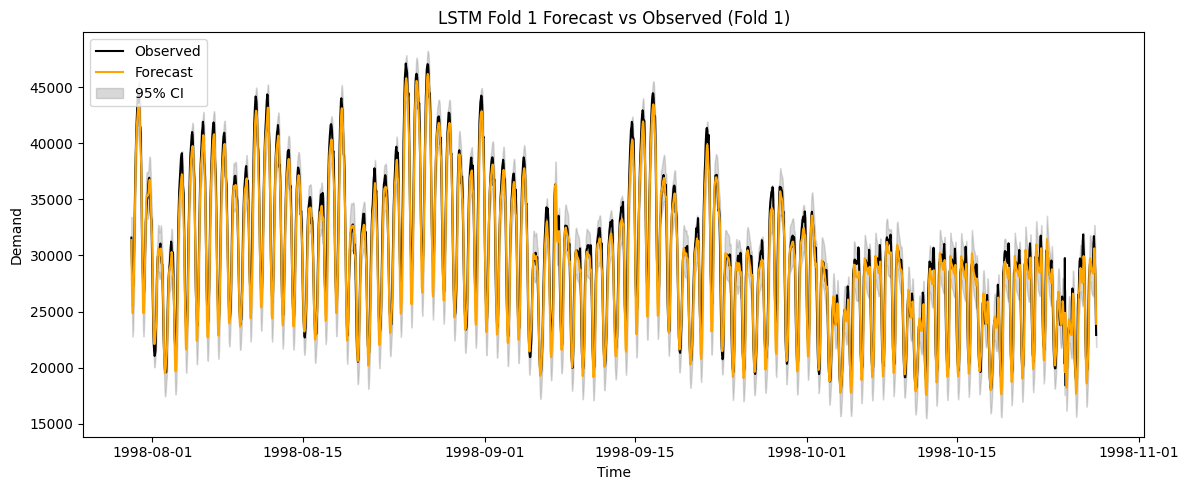

===== Fold 2 =====
Fold 2: train size=5760, test size=2160
Training LSTM on fold 2


Training time: 29.22 seconds
Fold 2 model saved to ./data/output/models/LSTM/LSTM_fold_2.h5
Inference time: 2.72 seconds

--- Evaluation Results for LSTM Fold 2 ---
RMSE: 915.4949
MAE: 666.4444
MAPE: 2.24%
R²: 0.9562


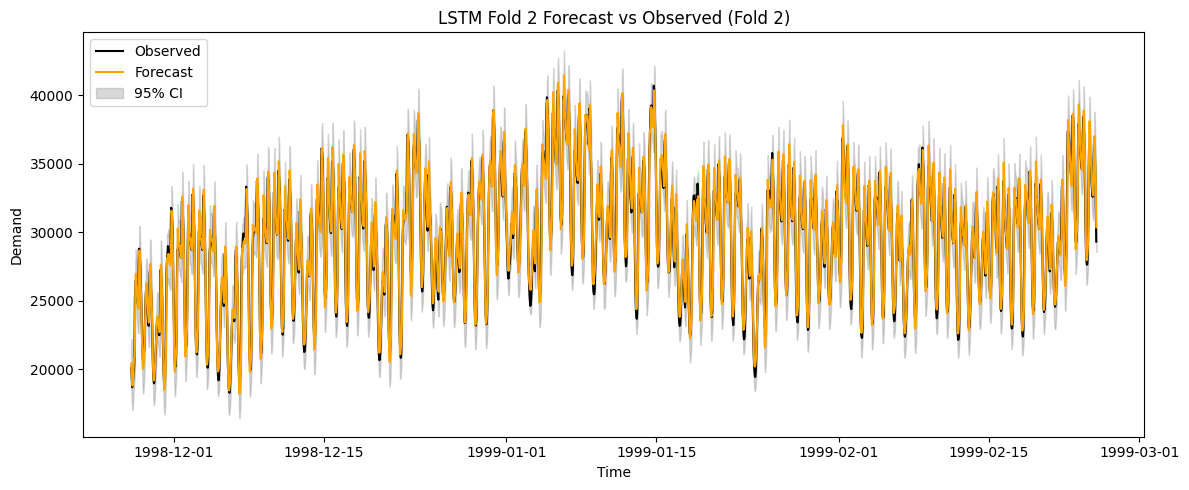

===== Fold 3 =====
Fold 3: train size=8640, test size=2160
Training LSTM on fold 3


Training time: 51.39 seconds
Fold 3 model saved to ./data/output/models/LSTM/LSTM_fold_3.h5
Inference time: 2.76 seconds

--- Evaluation Results for LSTM Fold 3 ---
RMSE: 861.1154
MAE: 611.5883
MAPE: 2.34%
R²: 0.9725


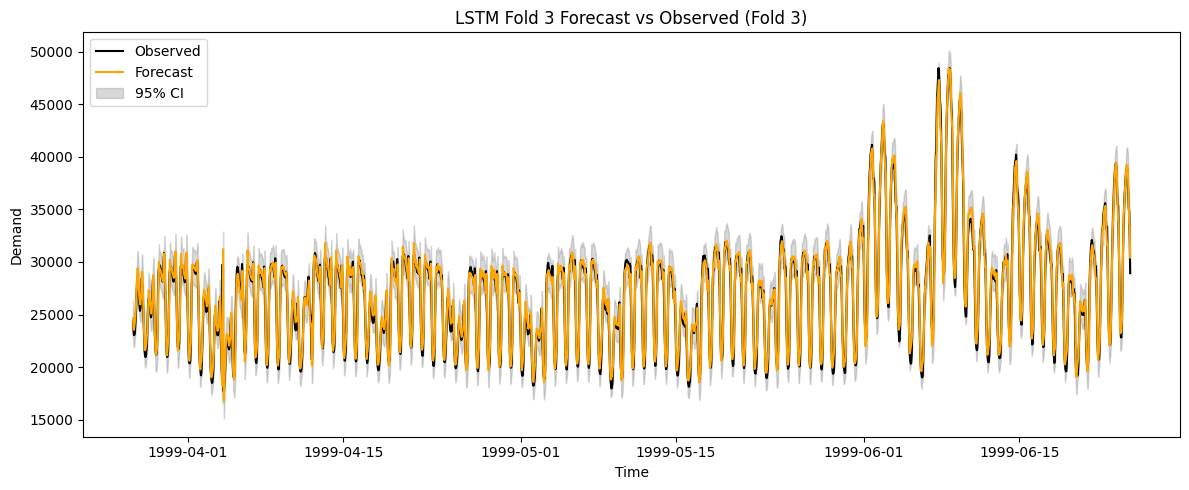

===== Fold 4 =====
Fold 4: train size=11520, test size=2160
Reducing train size to max 8760 samples
Training LSTM on fold 4


Training time: 53.90 seconds
Fold 4 model saved to ./data/output/models/LSTM/LSTM_fold_4.h5
Inference time: 2.73 seconds

--- Evaluation Results for LSTM Fold 4 ---
RMSE: 698.3575
MAE: 539.7983
MAPE: 1.82%
R²: 0.9893


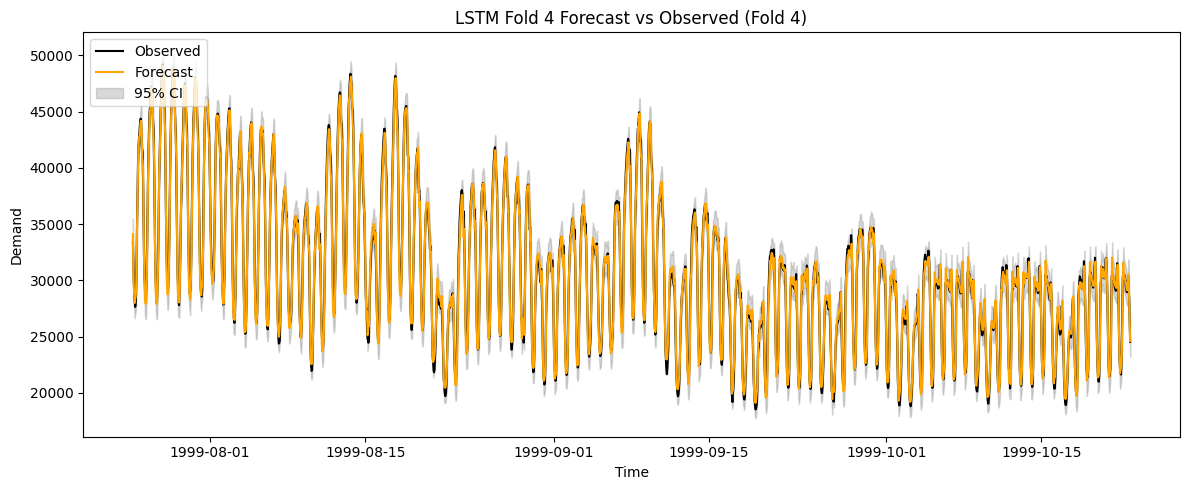

===== Fold 5 =====
Fold 5: train size=14400, test size=2160
Reducing train size to max 8760 samples
Training LSTM on fold 5


Training time: 41.51 seconds
Fold 5 model saved to ./data/output/models/LSTM/LSTM_fold_5.h5
Inference time: 1.50 seconds

--- Evaluation Results for LSTM Fold 5 ---
RMSE: 845.9027
MAE: 584.8054
MAPE: 1.88%
R²: 0.9682


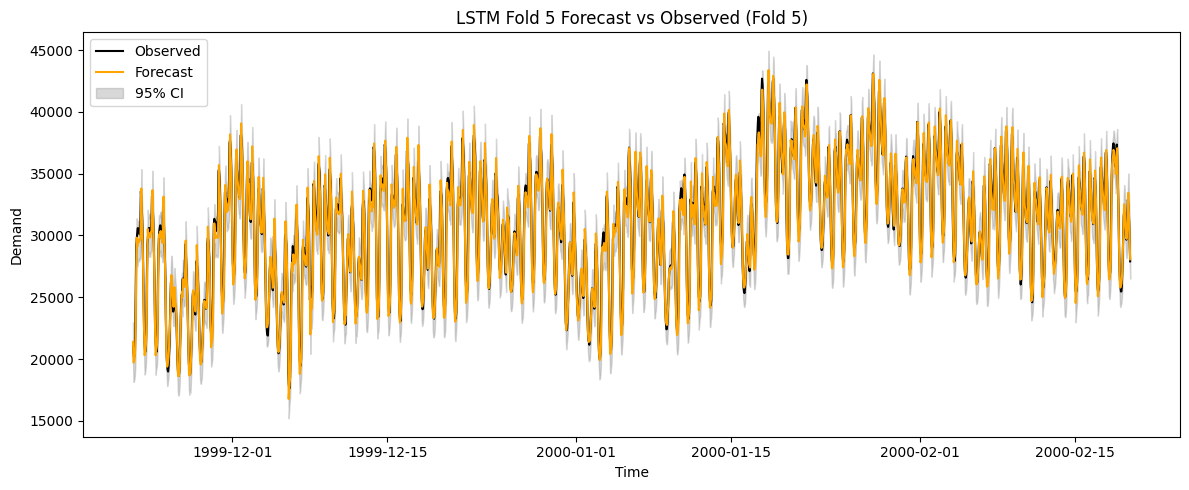

===== Fold 6 =====
Fold 6: train size=17280, test size=2160
Reducing train size to max 8760 samples
Training LSTM on fold 6


Training time: 37.89 seconds
Fold 6 model saved to ./data/output/models/LSTM/LSTM_fold_6.h5
Inference time: 2.76 seconds

--- Evaluation Results for LSTM Fold 6 ---
RMSE: 929.7206
MAE: 721.2288
MAPE: 2.75%
R²: 0.9688


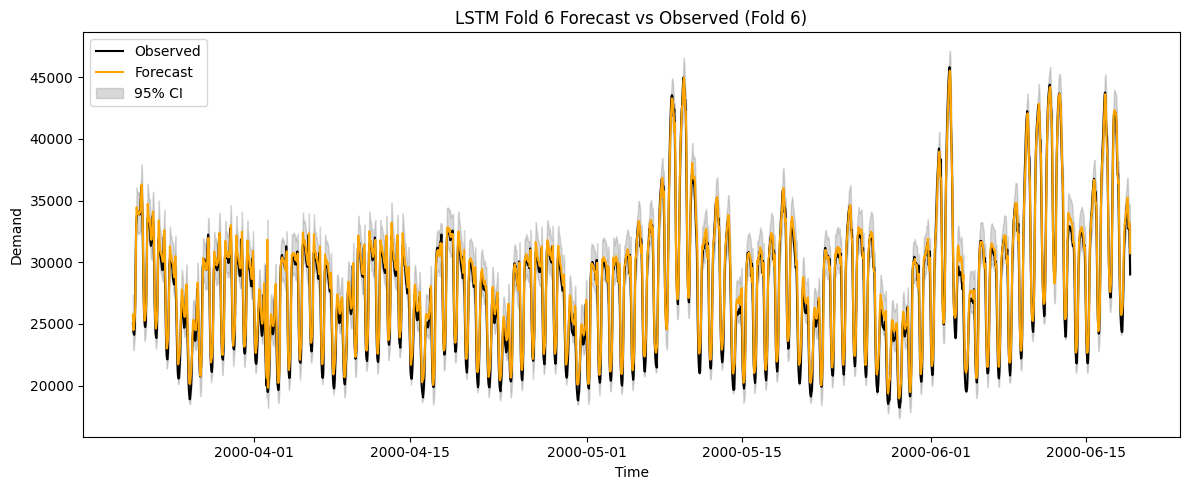

===== Fold 7 =====
Fold 7: train size=20160, test size=2160
Reducing train size to max 8760 samples
Training LSTM on fold 7


Training time: 38.62 seconds
Fold 7 model saved to ./data/output/models/LSTM/LSTM_fold_7.h5
Inference time: 2.72 seconds

--- Evaluation Results for LSTM Fold 7 ---
RMSE: 677.8634
MAE: 524.6649
MAPE: 1.79%
R²: 0.9879


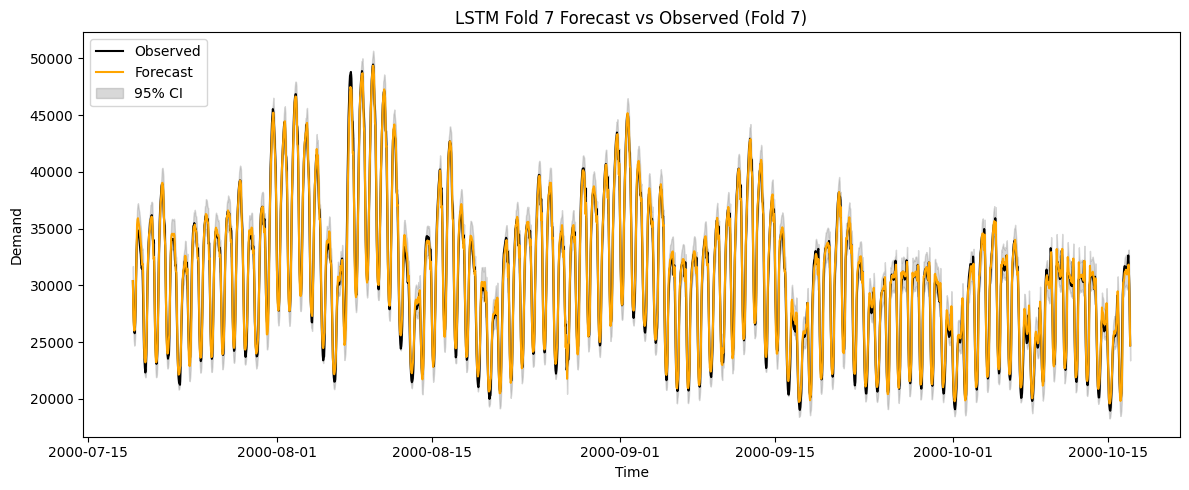

===== Fold 8 =====
Fold 8: train size=23040, test size=2160
Reducing train size to max 8760 samples
Training LSTM on fold 8


Training time: 43.27 seconds
Fold 8 model saved to ./data/output/models/LSTM/LSTM_fold_8.h5
Inference time: 1.88 seconds

--- Evaluation Results for LSTM Fold 8 ---
RMSE: 891.5446
MAE: 695.7959
MAPE: 2.15%
R²: 0.9497


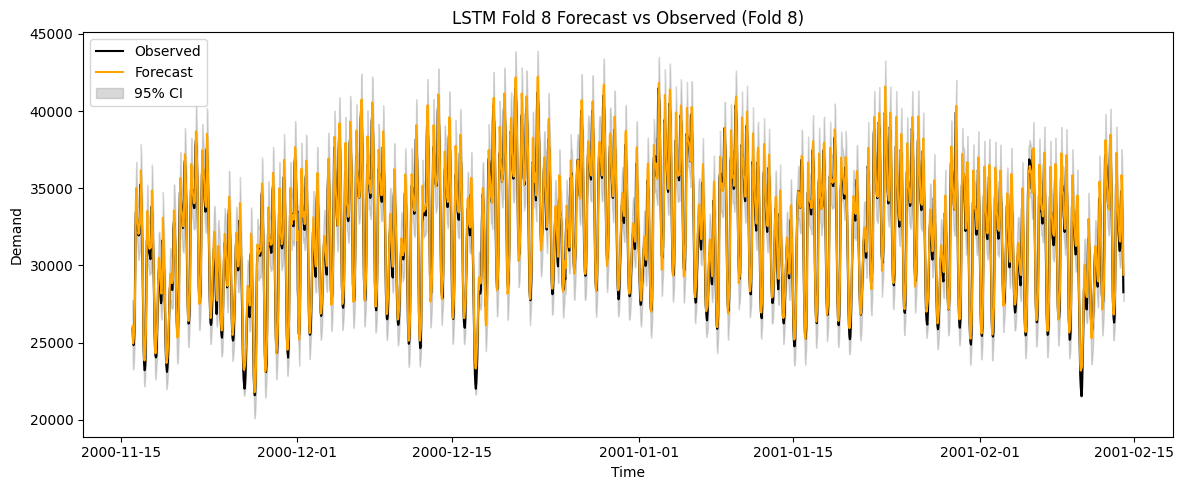

===== Fold 9 =====
Fold 9: train size=25920, test size=2160
Reducing train size to max 8760 samples
Training LSTM on fold 9


Training time: 39.04 seconds
Fold 9 model saved to ./data/output/models/LSTM/LSTM_fold_9.h5
Inference time: 1.43 seconds

--- Evaluation Results for LSTM Fold 9 ---
RMSE: 839.6653
MAE: 654.5771
MAPE: 2.43%
R²: 0.9677


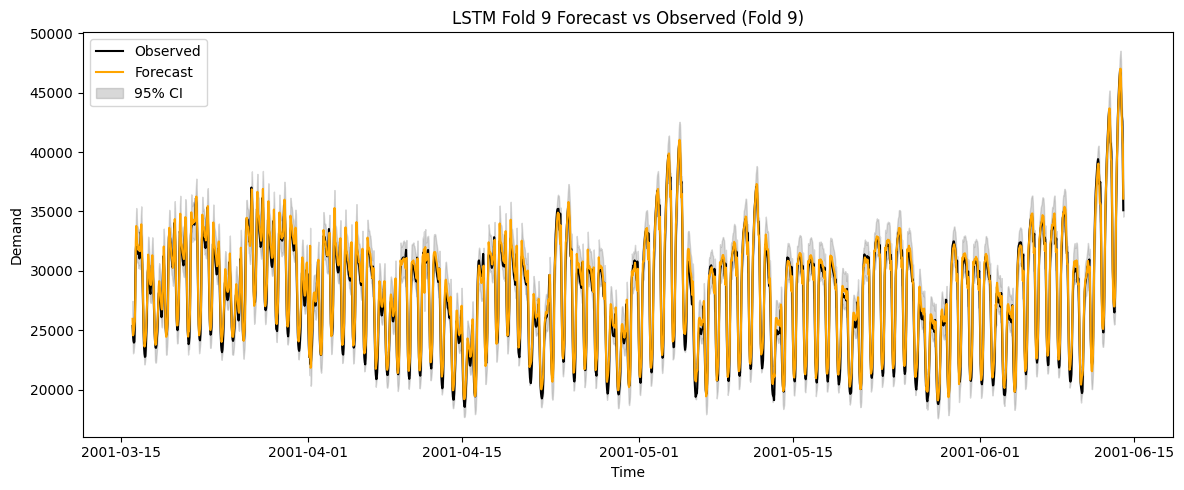

===== Fold 10 =====
Fold 10: train size=28800, test size=2160
Reducing train size to max 8760 samples
Training LSTM on fold 10


Training time: 42.75 seconds
Fold 10 model saved to ./data/output/models/LSTM/LSTM_fold_10.h5
Inference time: 2.76 seconds

--- Evaluation Results for LSTM Fold 10 ---
RMSE: 711.1282
MAE: 555.9882
MAPE: 1.79%
R²: 0.9906


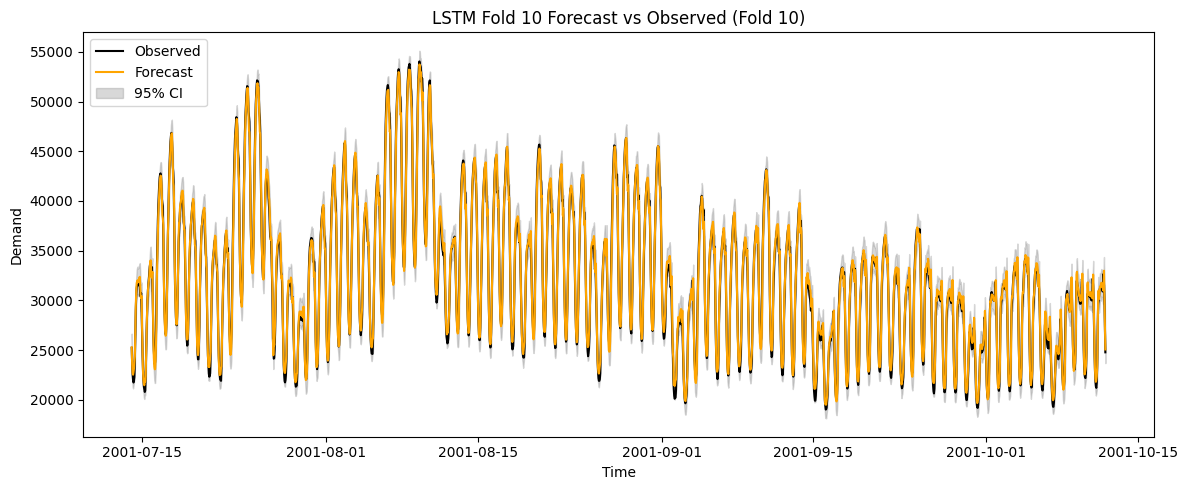

===== Average metrics across folds =====
RMSE: 857.8436
MAE: 649.7548
MAPE: 2.2436
R2: 0.9715


In [ ]:
lstm_model, lstm_all_metrics, lstm_avg_metrics = train_lstm_on_splits(
    splits= custom_expanding_window_splits,
    n_lags=24,
    min_train_size=24*30,
    max_train_size=24*365,
    epochs=10,
    batch_size=32
)

# Comparison

In [ ]:
from tensorflow.keras.models import load_model
from statsmodels.tsa.arima.model import ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
from joblib import load

loaded_models = {}

for model_name in ["ARIMA", "SARIMA", "Prophet", "HoltWinters", "XGBoost", "LightGBM", "LSTM"]:
    
    if model_name == "LSTM":
        model_path = f"./data/output/models/{model_name}/{model_name}_fold_10.h5"
    else:
        model_path = f"./data/output/models/{model_name}/{model_name}_fold_10.pkl"

    if model_name in ["ARIMA", "SARIMA"]:
        loaded_models[model_name] = SARIMAXResults.load(model_path)

    elif model_name in ["HoltWinters", "Prophet", "XGBoost", "LightGBM"]:
        with open(model_path, 'rb') as f:
            loaded_models[model_name] = pickle.load(f)

    elif model_name == "LSTM":
        loaded_models[model_name] = load_model(model_path, compile=False)

scaler_path = "./data/output/models/LSTM/LSTM_fold_10_scaler.pkl"
scaler = load(scaler_path)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_model(y_true, y_pred):
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "MAPE": mape(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }


In [ ]:
def generate_forecast(model_name, model, test, train=None, n_lags=24, scaler=None):
    if model_name == "ARIMA":
        return model.forecast(steps=len(test))
    
    elif model_name == "SARIMA":
        return model.forecast(steps=len(test))
    
    elif model_name == "HoltWinters":
        return model.forecast(steps=len(test))
    
    elif model_name == "Prophet":
        future = pd.DataFrame({'ds': test.index})
        forecast = model.predict(future)
        return forecast.set_index('ds')['yhat']
    
    elif model_name == "XGBoost" or model_name == "LightGBM":
        X_test = create_lag_features(pd.concat([train.tail(168), test]))  
        X_test = X_test.loc[test.index].drop(columns='demand')
        return model.predict(X_test)
    
    elif model_name == "LSTM":
        extended_index = train.index[-n_lags:].append(test.index)
        scaled = np.vstack([scaler.transform(train[['demand']])[-n_lags:], scaler.transform(test[['demand']])])
        df_test_seq = pd.DataFrame(scaled, index=extended_index, columns=['demand'])
        X_test, _ = create_lstm_sequences(df_test_seq, n_lags)
        preds_scaled = model.predict(X_test, verbose=0).flatten()
        preds = scaler.inverse_transform(preds_scaled.reshape(-1, 1)).flatten()
        return pd.Series(preds[-len(test):], index=test.index)


In [ ]:
def compare_all_models(loaded_models, test, train=None, n_lags=24, scaler=None):
    results = {}
    forecasts = {}

    for model_name, model in loaded_models.items():
        print(f"\n🔹 Forecasting with {model_name}...")
        
        preds = generate_forecast(model_name, model, test, train, n_lags, scaler)
        forecasts[model_name] = preds
        
        y_pred = np.array(preds)
        y_true = test['demand'].values
        
        results[model_name] = evaluate_model(y_true, y_pred)

    results_df = pd.DataFrame(results).T.sort_values("RMSE")
    print(results_df)
    return results_df, forecasts


In [ ]:
train_last, test_last = custom_expanding_window_splits[-1]

final_train_set = train_last
final_test_set = test_last

results_df, forecasts = compare_all_models(
    loaded_models, 
    test=final_test_set, 
    train=final_train_set, 
    n_lags=24, 
    scaler=scaler
)


🔹 Forecasting with ARIMA...

🔹 Forecasting with SARIMA...



🔹 Forecasting with Prophet...

🔹 Forecasting with HoltWinters...

🔹 Forecasting with XGBoost...

🔹 Forecasting with LightGBM...

🔹 Forecasting with LSTM...
                     RMSE          MAE       MAPE        R2
LSTM           711.128190   555.988219   1.791522  0.990600
XGBoost       1517.041968  1151.248856   3.577820  0.957223
LightGBM      1545.030063  1178.772828   3.663539  0.955630
SARIMA        5725.917615  4349.378524  12.562102  0.390592
ARIMA         7581.724905  5960.519054  18.186949 -0.068449
HoltWinters   9327.985375  7353.523212  20.964342 -0.617311
Prophet      10251.778759  8554.969792  30.066526 -0.953513


In [ ]:
def plot_forecasts_all(forecasts, test):
    plt.figure(figsize=(14, 6))
    plt.plot(test.index, test['demand'], label="Actual", color="black", linewidth=2)
    for name, preds in forecasts.items():
        plt.plot(test.index, preds, label=name, alpha=0.8)
    plt.title("Observed vs Forecast - All Models")
    plt.legend()
    plt.show()


def plot_metrics_bar(results_df):
    metrics = ["RMSE", "MAE", "MAPE"]
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i, metric in enumerate(metrics):
        results_df[metric].plot(kind="bar", ax=axes[i], title=f"{metric} Comparison")
        axes[i].set_ylabel(metric)
        axes[i].grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


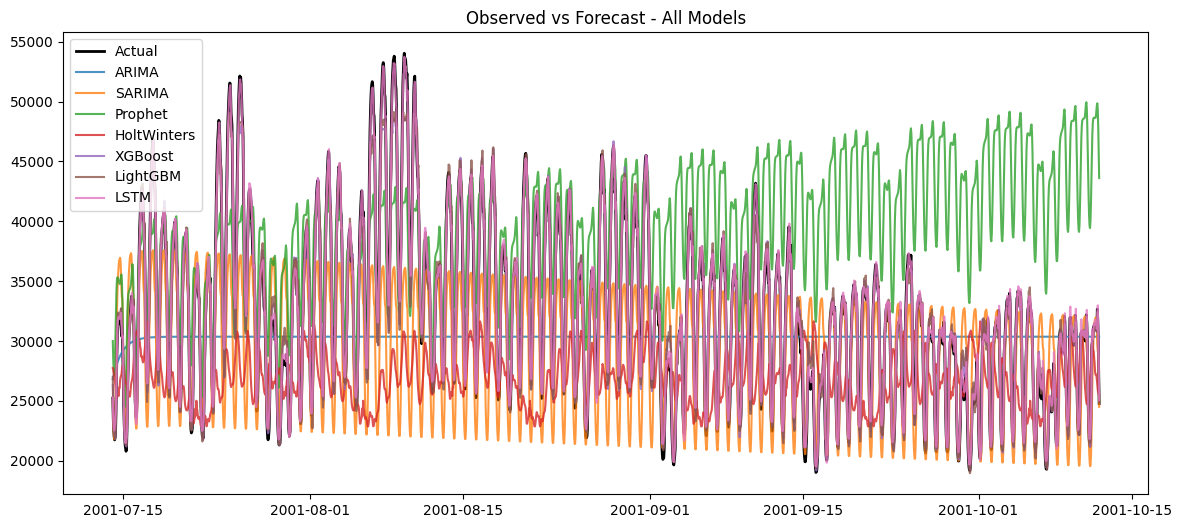

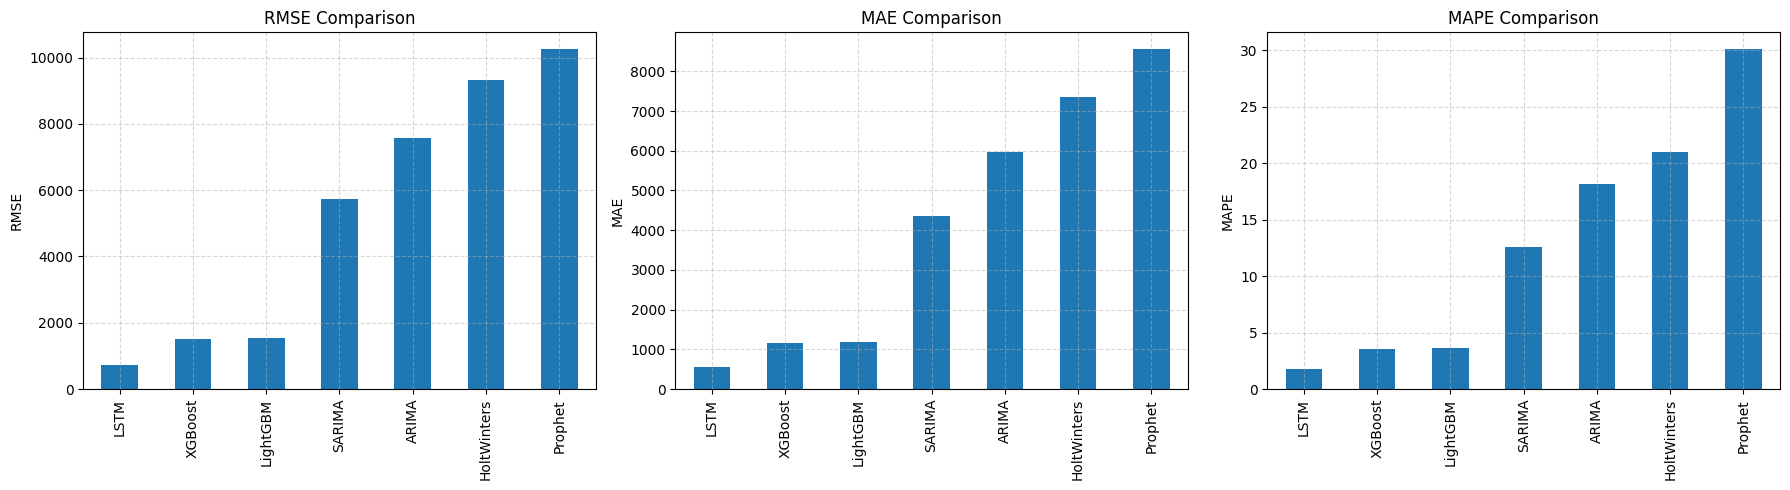

In [ ]:
plot_forecasts_all(forecasts, final_test_set)   
plot_metrics_bar(results_df)                   